In [42]:
from pathlib import Path
import polars as pl 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import altair as alt
import yaml
from datetime import date
import numpy as np
from varname import nameof
import polars.selectors as cs

In [2]:
with open('../config/cfg.yaml') as f:
    config = yaml.safe_load(f)

features = config['features']
target   = config["target"][0]
print(features)

['period_begin', 'period_end', 'region', 'state_code', 'median_sale_price', 'median_list_price', 'median_ppsf', 'homes_sold', 'inventory', 'new_listings', 'months_of_supply', 'median_dom', 'pending_sales', 'avg_sale_to_list', 'sold_above_list', 'price_drops', 'off_market_in_two_weeks', 'median_sale_price_mom', 'median_sale_price_yoy', 'months_of_supply_mom', 'months_of_supply_yoy', 'homes_sold_mom', 'homes_sold_yoy', 'inventory_mom', 'inventory_yoy', 'median_dom_mom', 'median_dom_yoy', 'price_drops_mom', 'price_drops_yoy', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings_mom', 'new_listings_yoy', 'property_type']


In [3]:
DATA_PATH         = Path("../data")
COUNTY_PATH       = DATA_PATH / "county_market_tracker.tsv000"
NEIGHBORHOOD_PATH = DATA_PATH / "neighborhood_market_tracker.tsv000"
STATE_PATH        = DATA_PATH / "state_market_tracker.tsv000"
US_NATION_PATH    = DATA_PATH / "us_national_market_tracker.tsv000"
ZIP_PATH          = DATA_PATH / "zip_code_market_tracker.tsv000"

In [4]:
county_df = pl.read_csv(COUNTY_PATH, separator="\t", columns=features).with_columns(
    pl.col("period_begin").cast(pl.Date()),
    pl.col("period_end").cast(pl.Date())
)
county_df.glimpse()

Rows: 563122
Columns: 34
$ period_begin            <date> 2017-04-01, 2014-12-01, 2018-02-01, 2017-08-01, 2019-05-01, 2017-06-01, 2019-12-01, 2018-06-01, 2018-07-01, 2014-11-01
$ period_end              <date> 2017-04-30, 2014-12-31, 2018-02-28, 2017-08-31, 2019-05-31, 2017-06-30, 2019-12-31, 2018-06-30, 2018-07-31, 2014-11-30
$ region                   <str> 'Morgan County, AL', 'Hennepin County, MN', 'Tulsa County, OK', 'Crow Wing County, MN', 'Tate County, MS', 'Walworth County, WI', 'Madison County, AL', 'Hamilton County, TX', 'Idaho County, ID', 'Guilford County, NC'
$ state_code               <str> 'AL', 'MN', 'OK', 'MN', 'MS', 'WI', 'AL', 'TX', 'ID', 'NC'
$ property_type            <str> 'All Residential', 'Multi-Family (2-4 Unit)', 'All Residential', 'Condo/Co-op', 'Single Family Residential', 'Single Family Residential', 'Multi-Family (2-4 Unit)', 'Single Family Residential', 'Single Family Residential', 'Condo/Co-op'
$ median_sale_price        <f64> 120500.0, 203000.0, 167500

In [5]:
county_df.null_count()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,685,52383,69332,43920,7395,679,52377,69325,79883,125130,142945,44898,82938,99747,22906,66101,84719,14964,58355,76113,8797,60417,77922,7931,5520,237761,264795,300991,66963


In [6]:
county_df.describe()

statistic,period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""563122""","""563122""","""563122""","""563122""","""563122""",562437.0,510739.0,493790.0,519202.0,555727.0,562443.0,510745.0,493797.0,483239.0,437992.0,420177.0,518224.0,480184.0,463375.0,540216.0,497021.0,478403.0,548158.0,504767.0,487009.0,554325.0,502705.0,485200.0,555191.0,557602.0,325361.0,298327.0,262131.0,496159.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",685.0,52383.0,69332.0,43920.0,7395.0,679.0,52377.0,69325.0,79883.0,125130.0,142945.0,44898.0,82938.0,99747.0,22906.0,66101.0,84719.0,14964.0,58355.0,76113.0,8797.0,60417.0,77922.0,7931.0,5520.0,237761.0,264795.0,300991.0,66963.0
"""mean""","""2017-03-14 16:01:17.073174""","""2017-04-13 02:47:53.468981""",null,null,null,204856.654317,1.167698,1.935374,232030.213737,1928.200556,121.35341,0.150434,0.347846,108.167373,0.167598,0.436182,154.916991,0.172941,0.259994,421.794199,0.009573,0.16447,5.701756,-0.138046,-0.988874,109.74947,-1.091533,-12.360146,0.959902,0.172628,0.200533,0.001515,0.004358,0.258053
"""std""",null,null,null,null,null,1.5061e6,388.591865,512.005735,1.9693e6,1.3414e6,347.492394,1.050092,3.983469,320.6543,1.254917,3.996148,430.174966,9.081662,7.013485,1118.946608,1.598657,8.601857,6.403006,7.539451,10.444344,195.650664,190.736681,202.129677,0.052256,0.192663,0.12395,0.092652,0.103921,0.249914
"""min""","""2012-01-01""","""2012-01-31""","""Abbeville County, SC""","""AK""","""All Residential""",1.0,-0.999996,-0.999994,100.0,0.00036,1.0,-0.972603,-0.988889,1.0,-0.9875,-0.982143,1.0,-0.995543,-0.994444,1.0,-0.959459,-0.992453,0.0,-1548.4,-1550.2,1.0,-8754.0,-15618.0,0.5,0.0,0.000058,-0.916667,-0.990566,0.0
"""25%""","""2014-10-01""","""2014-10-31""",null,null,null,115000.0,-0.096043,-0.043404,139900.0,71.743697,4.0,-0.195238,-0.117647,4.0,-0.2,-0.090909,7.0,-0.214286,-0.148148,21.0,-0.074286,-0.228049,2.5,-1.0,-2.0,41.0,-18.0,-32.0,0.942682,0.0,0.125926,-0.036976,-0.038988,0.0
"""50%""","""2017-05-01""","""2017-05-31""",null,null,null,163750.0,0.006536,0.075832,189900.0,99.027947,18.0,0.0,0.046218,15.0,0.0,0.105263,27.0,0.0,0.017544,85.0,-0.002326,-0.073892,4.2,0.0,-0.6,72.0,0.0,-7.0,0.968054,0.134021,0.183386,0.001292,0.001951,0.217391
"""75%""","""2019-09-01""","""2019-09-30""",null,null,null,238500.0,0.121857,0.221212,269950.0,136.258661,80.0,0.25,0.333333,68.0,0.285714,0.481481,110.0,0.269697,0.262295,331.0,0.055556,0.086849,7.0,0.9,0.5,120.0,16.0,12.0,0.986673,0.25,0.25,0.038642,0.043651,0.415385
"""max""","""2021-12-01""","""2021-12-31""","""Zavala County, TX""","""WV""","""Townhouse""",9.99999999e8,189999.0,220999.0,9.99999998e8,9.99999999e8,9186.0,250.0,696.0,8218.0,282.5,973.0,9899.0,4222.0,4222.0,26655.0,539.0,976.0,874.0,543.5,862.0,15811.0,15749.0,15774.0,1.963048,1.0,1.0,0.923077,0.954545,1.5


In [7]:
county_df.head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2017-04-01,2017-04-30,"""Morgan County, AL""","""AL""","""All Residential""",120500.0,-0.076628,-0.107077,147900.0,75.845434,106,-0.109244,-0.131148,48,0.0,-0.058824,140,0.196581,0.076923,439,0.068127,-0.142578,4.1,0.6,-0.1,101,-28,-10,0.960914,0.09434,null,null,null,0.020833
2014-12-01,2014-12-31,"""Hennepin County, MN""","""MN""","""Multi-Family (2-4 Unit)""",203000.0,-0.171429,0.052632,210000.0,86.633333,57,0.628571,-0.109375,29,0.0,-0.147059,21,-0.5625,-0.447368,133,-0.231214,-0.043165,2.3,-2.6,0.1,76,31,17,0.977672,0.245614,0.097744,-0.121909,-0.19722,0.172414
2018-02-01,2018-02-28,"""Tulsa County, OK""","""OK""","""All Residential""",167500.0,0.021341,0.101974,179700.0,89.76558,665,0.136752,0.084829,523,0.050201,-0.095156,941,0.08912,0.012917,2665,0.012538,0.002256,4.0,-0.5,-0.3,69,15,15,0.973126,0.177444,0.206004,-0.026139,0.009313,0.479924
2017-08-01,2017-08-31,"""Crow Wing County, MN""","""MN""","""Condo/Co-op""",125000.0,-0.137931,null,209900.0,147.076613,3,2.0,null,null,null,null,3,null,null,5,0.25,null,1.7,-2.3,null,107,-5,null,0.964538,0.0,0.2,-0.05,null,null
2019-05-01,2019-05-31,"""Tate County, MS""","""MS""","""Single Family Residential""",165000.0,-0.144635,-0.046243,181444.0,85.0,19,0.0,-0.05,6,-0.333333,-0.4,18,-0.181818,-0.142857,80,-0.036145,-0.02439,4.2,-0.2,0.1,117,17,-36,0.981283,0.157895,null,null,null,0.0


In [8]:
county_df = county_df.fill_null(strategy="mean")
county_df.null_count()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
county_df.sort("period_begin").group_by("period_begin").agg(pl.col("median_sale_price").mean()).plot.line(
    x="period_begin",
    y="median_sale_price"
).properties(
    width=700,
    height=500
).interactive()

alt.Chart(...)

In [10]:
county_df.filter(
    pl.col("period_begin").dt.year() == 2020
).sort("period_begin").group_by(pl.col("period_begin")).agg(pl.col(target).mean()).sort(target, descending=True)

period_begin,median_sale_price
date,f64
2020-08-01,443955.725739
2020-09-01,353603.636927
2020-10-01,260976.136142
2020-12-01,258914.736523
2020-11-01,257434.639791
…,…
2020-06-01,237098.737916
2020-05-01,236320.307852
2020-03-01,235490.922101


In [11]:
county_df.filter(
    pl.col("period_begin") == date(2020, 8, 1)
).sort(target, descending=True).head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2020-08-01,2020-08-31,"""Union County, OH""","""OH""","""Multi-Family (2-4 Unit)""",9.99999999e8,1.167698,2208.944749,232030.213737,9.99999999e8,1,0.150434,0.0,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,109,-1,-12,1.0,0.0,0.200533,0.001515,0.004358,0.258053
2020-08-01,2020-08-31,"""New York County, NY""","""NY""","""Townhouse""",5.5e6,1.167698,1.935374,1.175e6,1003.649635,1,0.150434,0.347846,108,0.167598,0.436182,1,0.172941,0.259994,15,0.009573,0.16447,15.0,-0.138046,-0.988874,178,-1,-12,1.0,0.0,0.133333,0.001515,0.004358,0.258053
2020-08-01,2020-08-31,"""Nantucket County, MA""","""MA""","""All Residential""",3.425e6,-0.03146,1.446429,2.695e6,914.504717,4,-0.5,-0.333333,15,0.666667,1.5,16,-0.238095,1.0,47,-0.078431,-0.145455,11.8,5.4,2.6,73,-46,-17,0.971717,0.25,0.170213,-0.006258,-0.102515,0.066667
2020-08-01,2020-08-31,"""Nantucket County, MA""","""MA""","""Single Family Residential""",3.425e6,-0.03146,1.446429,2.695e6,914.504717,4,-0.5,-0.333333,15,1.5,1.5,16,-0.157895,1.0,46,-0.061224,-0.098039,11.5,5.4,3.0,73,-46,-17,0.971717,0.25,0.152174,0.009317,-0.102728,0.066667
2020-08-01,2020-08-31,"""New York County, NY""","""NY""","""Single Family Residential""",3.25e6,-0.811594,-0.044118,1.175e6,938.009788,4,0.0,0.0,1,0.167598,-0.5,19,-0.095238,0.461538,102,0.120879,0.030303,25.5,2.7,0.7,338,-424,111,1.0,0.0,0.392157,0.01853,0.260844,1.0


- Very large outlier in ohio

In [12]:
Q1 = county_df[target].quantile(0.25)
Q3 = county_df[target].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
outliers = county_df.filter(
    (pl.col(target) < np.abs(Q1 - 1.5*IQR)) |
    (pl.col(target) > np.abs(Q3 + 1.5*IQR))
)
outliers.sort(target, descending=True)

115000.0 238250.0 123250.0


period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2020-08-01,2020-08-31,"""Union County, OH""","""OH""","""Multi-Family (2-4 Unit)""",9.99999999e8,1.167698,2208.944749,232030.213737,9.99999999e8,1,0.150434,0.0,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,109,-1,-12,1.0,0.0,0.200533,0.001515,0.004358,0.258053
2020-09-01,2020-09-30,"""Fayette County, OH""","""OH""","""Condo/Co-op""",5.0010e8,1.167698,1.935374,152200.0,40557.783138,2,0.150434,0.347846,1,0.167598,0.436182,1,0.172941,0.259994,1,0.009573,0.16447,0.5,-0.138046,-0.988874,1,-1,-12,1.0,0.0,1.0,0.001515,0.004358,1.0
2017-11-01,2017-11-30,"""New York County, NY""","""NY""","""Townhouse""",2.6375e7,1.167698,10.722222,232030.213737,1608.981965,2,0.150434,1.0,1,0.167598,0.436182,154,0.172941,0.259994,35,0.009573,-0.375,17.5,-0.138046,-38.5,176,-1,-1456,1.0,0.0,0.114286,0.001515,0.004358,0.0
2017-08-01,2017-08-31,"""New York County, NY""","""NY""","""Townhouse""",2.25e7,2.797468,0.574803,1.225e6,674.157303,2,1.0,0.0,108,0.167598,0.436182,3,0.0,0.5,32,0.032258,-0.567568,16.0,-15.0,-21.0,394,263,323,0.917827,0.0,0.125,-0.294355,0.004358,0.258053
2019-06-01,2019-06-30,"""New York County, NY""","""NY""","""Townhouse""",2.065e7,1.167698,1.56124,1.215e6,2560.714286,4,0.150434,0.0,2,0.167598,0.436182,5,0.172941,1.5,19,0.009573,-0.321429,4.8,-0.138046,-2.2,495,-1,-98,1.0,0.0,0.210526,0.001515,-0.110902,0.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2017-03-01,2017-03-31,"""Ashtabula County, OH""","""OH""","""Multi-Family (2-4 Unit)""",1.0,-0.999972,-0.999956,89900.0,0.000488,1,-0.5,-0.5,3,2.0,0.0,9,2.0,1.25,26,0.130435,0.083333,26.0,14.5,14.0,97,53,54,0.959902,0.0,0.153846,0.110368,-0.054487,0.0
2012-11-01,2012-11-30,"""Miami County, OH""","""OH""","""Multi-Family (2-4 Unit)""",1.0,-0.999987,-0.999986,110900.0,0.000371,1,-0.75,0.0,2,-0.5,1.0,4,0.0,0.333333,20,0.052632,-0.310345,20.0,15.2,-9.0,175,123,92,0.959902,0.0,0.200533,0.001515,0.004358,0.0
2018-04-01,2018-04-30,"""Andrew County, MO""","""MO""","""Townhouse""",1.0,1.167698,1.935374,232030.213737,0.00036,1,0.150434,0.347846,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,258,-1,-12,0.959902,0.0,0.200533,0.001515,0.004358,0.258053


In [13]:
county_df_clean = county_df.filter(
    (pl.col(target) >= np.abs(Q1 - 1.5*IQR)) &
    (pl.col(target) <= np.abs(Q3 + 1.5*IQR))
)
county_df_clean.sort(target)

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2021-12-01,2021-12-31,"""Cleveland County, OK""","""OK""","""Condo/Co-op""",69875.0,-0.240489,-0.177941,225000.0,77.624461,10,-0.090909,0.428571,8,-0.111111,1.666667,5,-0.166667,1.5,5,-0.444444,-0.545455,0.5,-0.3,-1.1,70,13,-11,0.971946,0.2,0.2,0.088889,0.018182,0.5
2014-03-01,2014-03-31,"""Manitowoc County, WI""","""WI""","""Multi-Family (2-4 Unit)""",69875.0,0.193934,-0.001786,99900.0,48.076923,4,0.0,-0.333333,3,0.167598,0.0,10,0.666667,0.428571,41,0.078947,0.242424,10.3,0.8,4.8,71,-91,-8,0.812312,0.0,0.200533,0.001515,0.004358,0.0
2014-03-01,2014-03-31,"""Orleans County, NY""","""NY""","""Single Family Residential""",69875.0,0.008457,0.0298,64900.0,47.340628,28,1.153846,0.166667,9,2.0,0.8,32,0.230769,-0.304348,175,-0.022346,-0.048913,6.3,-7.5,-1.4,192,24,-64,0.935337,0.142857,0.200533,0.001515,0.004358,0.0
2014-03-01,2014-03-31,"""Orleans County, NY""","""NY""","""All Residential""",69875.0,0.008457,0.0298,64900.0,47.340628,28,1.153846,0.166667,9,2.0,0.8,34,0.259259,-0.276596,183,-0.02139,-0.071066,6.5,-7.9,-1.7,192,24,-64,0.935337,0.142857,0.200533,0.001515,0.004358,0.0
2016-10-01,2016-10-31,"""Greene County, IA""","""IA""","""Single Family Residential""",69875.0,-0.653118,0.751253,70950.0,60.655382,7,2.5,0.4,4,3.0,1.0,4,-0.555556,0.0,34,-0.105263,0.36,4.9,-14.1,-0.1,97,41,-92,0.91223,0.0,0.200533,0.001515,0.004358,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-07-01,2016-07-31,"""Los Angeles County, CA""","""CA""","""Condo/Co-op""",423000.0,0.007143,0.065491,550000.0,393.87164,1098,-0.110931,-0.104405,1082,-0.064823,-0.052539,1527,0.031757,0.014618,2796,0.087515,0.046016,2.5,0.4,0.3,29,-3,0,0.999186,0.387978,0.187768,-0.009431,-0.041562,0.354898
2018-12-01,2018-12-31,"""Rockland County, NY""","""NY""","""All Residential""",423000.0,0.043157,0.044444,436000.0,220.883534,248,0.227723,-0.019763,142,-0.059603,0.314815,138,-0.389381,0.0,907,-0.154706,0.013408,3.7,-1.6,0.2,76,7,16,0.970493,0.149194,0.154355,-0.058133,0.045975,0.091549
2018-08-01,2018-08-31,"""Fauquier County, VA""","""VA""","""Single Family Residential""",423062.5,0.024364,0.092902,394500.0,175.661914,96,-0.067961,-0.172414,62,-0.205128,0.016393,111,-0.034783,-0.017699,376,0.050279,-0.109005,3.9,0.4,0.3,46,18,13,0.983716,0.125,0.335106,-0.002882,0.107618,0.322581


In [14]:
county_sample = county_df_clean.select(
    pl.col(target)
).sample(
    n=100_000,
    seed=42
)
county_sample.shape

adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(county_sample)

if pvalue < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary and need to difference")

Series is stationary


In [15]:
county_df_clean.select(target).to_numpy()

array([[120500.],
       [203000.],
       [167500.],
       ...,
       [173990.],
       [170000.],
       [128000.]], shape=(484040, 1))

In [16]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
# plot_acf(county_df_clean.select(target).to_numpy(), lags=20, ax=ax1)
# plot_pacf(county_df_clean.select(target).to_numpy(), lags=20, ax=ax2)
# plt.show()

# model = ARIMA(county_df_clean.select(target).to_numpy(), order=(1, 0, 1))
# fitted = model.fit()
# print(fitted.summary())

In [17]:
county_df_clean[:1000].select(["period_begin", target]).plot.line(
    x="period_begin",
    y=target
)

alt.Chart(...)

- No autocorrelation is a problem for ARIMA, it's probably because there are different property types

In [18]:
property_types = county_df_clean.select('property_type').unique().to_numpy()

In [19]:
county_df_clean["property_type"].value_counts()

property_type,count
str,u32
"""All Residential""",156976
"""Townhouse""",53160
"""Condo/Co-op""",67234
"""Single Family Residential""",155420
"""Multi-Family (2-4 Unit)""",51250


In [20]:
county_df.head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2017-04-01,2017-04-30,"""Morgan County, AL""","""AL""","""All Residential""",120500.0,-0.076628,-0.107077,147900.0,75.845434,106,-0.109244,-0.131148,48,0.0,-0.058824,140,0.196581,0.076923,439,0.068127,-0.142578,4.1,0.6,-0.1,101,-28,-10,0.960914,0.09434,0.200533,0.001515,0.004358,0.020833
2014-12-01,2014-12-31,"""Hennepin County, MN""","""MN""","""Multi-Family (2-4 Unit)""",203000.0,-0.171429,0.052632,210000.0,86.633333,57,0.628571,-0.109375,29,0.0,-0.147059,21,-0.5625,-0.447368,133,-0.231214,-0.043165,2.3,-2.6,0.1,76,31,17,0.977672,0.245614,0.097744,-0.121909,-0.19722,0.172414
2018-02-01,2018-02-28,"""Tulsa County, OK""","""OK""","""All Residential""",167500.0,0.021341,0.101974,179700.0,89.76558,665,0.136752,0.084829,523,0.050201,-0.095156,941,0.08912,0.012917,2665,0.012538,0.002256,4.0,-0.5,-0.3,69,15,15,0.973126,0.177444,0.206004,-0.026139,0.009313,0.479924
2017-08-01,2017-08-31,"""Crow Wing County, MN""","""MN""","""Condo/Co-op""",125000.0,-0.137931,1.935374,209900.0,147.076613,3,2.0,0.347846,108,0.167598,0.436182,3,0.172941,0.259994,5,0.25,0.16447,1.7,-2.3,-0.988874,107,-5,-12,0.964538,0.0,0.2,-0.05,0.004358,0.258053
2019-05-01,2019-05-31,"""Tate County, MS""","""MS""","""Single Family Residential""",165000.0,-0.144635,-0.046243,181444.0,85.0,19,0.0,-0.05,6,-0.333333,-0.4,18,-0.181818,-0.142857,80,-0.036145,-0.02439,4.2,-0.2,0.1,117,17,-36,0.981283,0.157895,0.200533,0.001515,0.004358,0.0


In [21]:
# for prop_type in property_types:
#     prop_data = county_df_clean.sort("period_begin").filter(
#         pl.col("region").is_in(["Mecklenburg County, NC"]),
#         pl.col("property_type") == prop_type[0]
#     )

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
#     plot_acf(county_df_clean.select(target).to_numpy().flatten(), lags=20, ax=ax1)
#     plot_pacf(county_df_clean.select(target).to_numpy().flatten(), lags=20, ax=ax2)
#     plt.show()

    # model = ARIMA(county_df_clean.select(target).to_numpy().flatten(), order=(1, 0, 1))
    # fitted = model.fit()
    # print(f"\n{prop_type[0]}")
    # print(fitted.summary())

In [22]:
county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC").group_by("property_type").agg(
    pl.col(target).mean().alias("target_mean"), 
    pl.col(target).std().alias("target_std"),
    pl.col(target).min().alias("target_min"),
    pl.col(target).max().alias("target_max"),
    pl.col(target).count().alias("target_count"),
).sort("target_mean")

property_type,target_mean,target_std,target_min,target_max,target_count
str,f64,f64,f64,f64,u32
"""Multi-Family (2-4 Unit)""",207834.182292,95285.762986,70000.0,409000.0,96
"""Condo/Co-op""",210126.023585,55706.236732,82750.0,342500.0,106
"""Townhouse""",229826.777174,70111.679809,70000.0,365250.0,92
"""All Residential""",245412.560748,53671.121975,166500.0,385000.0,107
"""Single Family Residential""",250932.504673,61491.787406,167500.0,405539.0,107


In [23]:
single_family   = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Single Family Residential")
multi_family    = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Multi-Family (2-4 Unit)")
condo_coop      = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Condo/Co-op")
townhouse       = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Townhouse")
all_residential = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "All Residential")

In [24]:
single_family_model = ARIMA(single_family.select(target).to_numpy().flatten(), order=(1, 1, 1))
multi_family_model  = ARIMA(multi_family.select(target).to_numpy().flatten(), order=(1, 1, 1))
condo_coop_model = ARIMA(condo_coop.select(target).to_numpy().flatten(), order=(1, 1, 1))
townhouse_model = ARIMA(townhouse.select(target).to_numpy().flatten(), order=(1, 1, 1))
all_residential_model = ARIMA(all_residential.select(target).to_numpy().flatten(), order=(1, 1, 1))

In [25]:
single_family_fit = single_family_model.fit()
multi_family_fit = multi_family_model.fit()
condo_coop_fit = condo_coop_model.fit()
townhouse_fit = townhouse_model.fit()
all_residential_fit = all_residential_model.fit()
all_fits = [single_family_fit, multi_family_fit, condo_coop_fit, townhouse_fit, all_residential_fit]

/home/rojacobeus/Documents/projects/Real-Estate-Market-Timing-Investment-Risk-Stratification/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [26]:
i = 1
for fit in all_fits:
    print(f"Fit {i}", "#"*50, sep="\n")
    print(fit.summary())
    print("\n")
    i += 1

Fit 1
##################################################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1322.004
Date:                Fri, 28 Nov 2025   AIC                           2650.008
Time:                        20:51:45   BIC                           2657.999
Sample:                             0   HQIC                          2653.247
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.126      0.054      0.957      -0.240       0.253
ma.L1         -0.9115      0.057    -16.116      0.000      -1.022      -0

In [27]:
condo_coop_forecast = condo_coop_fit.get_forecast(steps=12)
condo_coop_forecast_df = pl.from_pandas(condo_coop_forecast.summary_frame())

In [28]:
condo_coop_forecast_df

mean,mean_se,mean_ci_lower,mean_ci_upper
f64,f64,f64,f64
207656.325839,63154.382576,83876.010525,331436.641153
206541.722163,63189.708116,82692.170063,330391.274263
206521.794859,63197.313851,82657.335791,330386.253926
206521.438591,63204.594639,82642.709442,330400.16774
206521.432221,63211.86885,82628.44588,330414.418562
…,…,…,…
206521.432105,63233.686151,82585.684639,330457.179571
206521.432105,63240.956912,82571.434211,330471.43
206521.432105,63248.226836,82557.18542,330485.678791


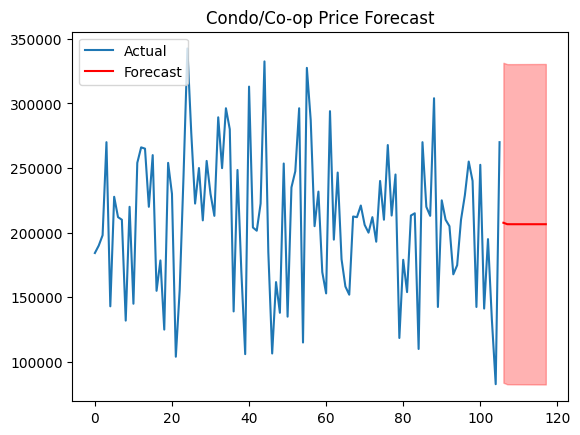

In [29]:
plt.plot(condo_coop[target],label="Actual")
plt.plot(range(len(condo_coop), len(condo_coop) + 12),
         condo_coop_forecast_df["mean"], label="Forecast", color="red"
)
plt.fill_between(range(len(condo_coop), len(condo_coop) + 12),
                 condo_coop_forecast_df["mean_ci_lower"], condo_coop_forecast_df["mean_ci_upper"],
                 alpha=0.3, color="red")

plt.legend()
plt.title("Condo/Co-op Price Forecast")
plt.show()

<Figure size 1500x700 with 0 Axes>

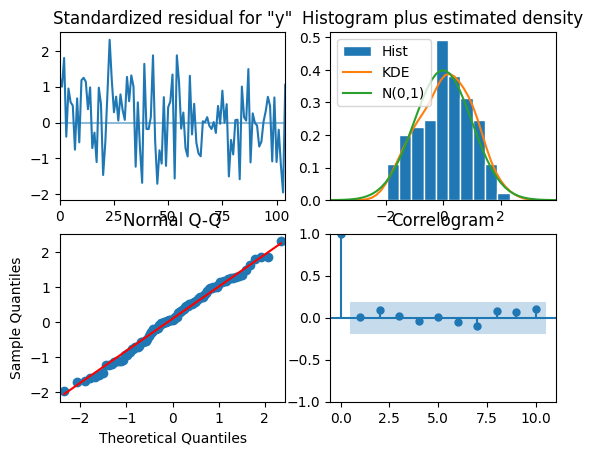

In [30]:
plt.figure(figsize=(15, 7))
condo_coop_fit.plot_diagnostics()
plt.show()

In [31]:
chart1 = alt.Chart(condo_coop_forecast_df).encode(
    x=alt.X(range(len(condo_coop), len(condo_coop) + 12)),
    y=alt.Y("mean:Q")
)
chart1

SchemaValidationError: '[106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]' is an invalid value for `field`. Valid values are of type `str | Mapping[str, Any]`.

alt.Chart(...)

In [60]:
meck_data = county_df_clean.filter(
    pl.col("region") == "Mecklenburg County, NC"
).sort("period_begin")

In [63]:
meck_data.select("property_type").unique().to_numpy().flatten()

array(['Townhouse', 'Multi-Family (2-4 Unit)', 'All Residential',
       'Single Family Residential', 'Condo/Co-op'], dtype=object)

In [72]:
selection = alt.selection_point(fields=["property_type"], bind="legend")

alt.Chart(meck_data).mark_line().encode(
    x=alt.X('period_begin:T'),
    y=alt.Y(f'{target}:Q'),
    color=alt.Color('property_type:N', title='Property Type'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).properties(
    width=800,
    height=400,
    title="Mecklenburg County - All Property Types Median Sale Price"
).add_params(selection).interactive()

alt.Chart(...)

In [81]:
meck_data.select(cs.float())

median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold_mom,homes_sold_yoy,pending_sales_mom,pending_sales_yoy,new_listings_mom,new_listings_yoy,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
155000.0,1.167698,1.935374,200150.0,58.873986,0.150434,0.347846,0.167598,0.436182,0.172941,0.259994,0.009573,0.16447,10.0,-0.138046,-0.988874,0.823558,0.166667,0.066667,0.001515,0.004358,0.25
166500.0,1.167698,1.935374,200150.0,86.206897,0.150434,0.347846,0.167598,0.436182,0.172941,0.259994,0.009573,0.16447,7.0,-0.138046,-0.988874,0.968748,0.214211,0.084253,0.001515,0.004358,0.090634
115000.0,1.167698,1.935374,200150.0,120.798319,0.150434,0.347846,0.167598,0.436182,0.172941,0.259994,0.009573,0.16447,381.0,-0.138046,-0.988874,0.719199,0.0,0.086614,0.001515,0.004358,0.159091
167500.0,1.167698,1.935374,200150.0,86.206897,0.150434,0.347846,0.167598,0.436182,0.172941,0.259994,0.009573,0.16447,6.5,-0.138046,-0.988874,0.969931,0.214737,0.083414,0.001515,0.004358,0.082077
145000.0,0.26087,1.935374,209816.0,166.148391,3.0,0.347846,0.167598,0.436182,-0.207317,0.259994,0.028871,0.16447,98.0,-283.0,-0.988874,1.013761,0.25,0.114796,0.028182,0.004358,0.092593
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
389070.0,-0.189438,0.161403,360000.0,219.392736,0.777778,1.285714,0.167598,0.436182,-0.333333,-0.333333,-0.181818,-0.653846,0.6,-0.6,-3.1,1.00469,0.25,0.222222,0.040404,0.068376,0.428571
403250.0,-0.005644,0.237153,360000.0,200.115506,-0.021084,-0.116848,0.167598,0.436182,-0.319957,-0.288309,-0.158685,-0.378236,0.9,-0.2,-0.4,1.014418,0.51,0.128292,-0.063988,0.022112,0.201175
335000.0,0.028879,0.213219,360000.0,192.853091,-0.02071,0.067742,0.167598,0.436182,-0.331731,-0.276042,-0.185,-0.413669,1.0,-0.2,-0.8,1.009124,0.432024,0.06135,-0.08365,-0.008794,0.156863


In [82]:
for col in meck_data.select(cs.float()).drop(["pending_sales_mom", "pending_sales_yoy"]).columns:
    adf_stat, p_val, *_ = adfuller(meck_data.select(col))
    print(f"{col}: {"Stationary" if p_val < 0.05 else "Non-stationary"} (p={p_val:.4f})")

median_sale_price: Non-stationary (p=0.9174)
median_sale_price_mom: Stationary (p=0.0000)
median_sale_price_yoy: Stationary (p=0.0268)
median_list_price: Non-stationary (p=0.8752)
median_ppsf: Non-stationary (p=0.9823)
homes_sold_mom: Stationary (p=0.0000)
homes_sold_yoy: Non-stationary (p=0.2773)
new_listings_mom: Stationary (p=0.0000)
new_listings_yoy: Non-stationary (p=0.1102)
inventory_mom: Stationary (p=0.0000)
inventory_yoy: Non-stationary (p=0.8243)
months_of_supply: Non-stationary (p=0.1642)
months_of_supply_mom: Stationary (p=0.0000)
months_of_supply_yoy: Stationary (p=0.0000)
avg_sale_to_list: Stationary (p=0.0011)
sold_above_list: Non-stationary (p=0.2323)
price_drops: Stationary (p=0.0001)
price_drops_mom: Stationary (p=0.0000)
price_drops_yoy: Stationary (p=0.0017)
off_market_in_two_weeks: Stationary (p=0.0428)


In [85]:
meck_data.select(target)

median_sale_price
f64
155000.0
166500.0
115000.0
167500.0
145000.0
…
389070.0
403250.0
335000.0


In [87]:
type(meck_data)

polars.dataframe.frame.DataFrame

In [88]:
model = ARIMA(meck_data.select(target).to_numpy(), order=(1, 1, 1))
results = model.fit()

In [90]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  508
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6187.521
Date:                Fri, 28 Nov 2025   AIC                          12381.042
Time:                        21:48:39   BIC                          12393.727
Sample:                             0   HQIC                         12386.016
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0509      0.060     -0.847      0.397      -0.169       0.067
ma.L1         -0.9269      0.023    -40.465      0.000      -0.972      -0.882
sigma2      2.816e+09   6.89e-13   4.09e+21      0.000    2.82e+09    2.82e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.71   Prob(JB):                         0.41
Heteroskedasticity (H):               1.00   Skew:                            -0.09
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+37. Standard errors may be unstable.
"""

In [91]:
model = ARIMA(meck_data.select(target).to_numpy(), order=(0, 1, 1))
results = model.fit()

In [92]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  508
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6188.103
Date:                Fri, 28 Nov 2025   AIC                          12380.206
Time:                        21:53:42   BIC                          12388.663
Sample:                             0   HQIC                         12383.523
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9317      0.021    -45.349      0.000      -0.972      -0.891
sigma2      2.822e+09    8.1e-14   3.48e+22      0.000    2.82e+09    2.82e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.16   Prob(JB):                         0.41
Heteroskedasticity (H):               1.01   Skew:                            -0.09
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

## AI From this point on

In [96]:
meck_sfr = meck_data.filter(                             
    pl.col('property_type') == 'Single Family Residential'                                                           
).sort('period_begin')                                                                                               
                            
model = ARIMA(meck_sfr['median_sale_price'].to_numpy(), order=(0, 1, 1))                                                        
results = model.fit()  

In [97]:
forecast_steps = 12
forecast = results.forecast(steps=forecast_steps)
forecast_ci = results.get_forecast(steps=forecast_steps).conf_int()

In [98]:
forecast_ci

array([[383534.03942842, 422896.8022863 ],
       [375193.93975412, 431236.9019606 ],
       [368819.92650872, 437610.915206  ],
       [363454.92966629, 442975.91204843],
       [358732.3534269 , 447698.48828782],
       [354465.13966544, 451965.70204927],
       [350542.50044697, 455888.34126774],
       [346892.39561167, 459538.44610305],
       [343464.85767094, 462965.98404378],
       [340223.54495766, 466207.29675705],
       [337141.04566069, 469289.79605403],
       [334196.07801857, 472234.76369615]])

In [102]:
from dateutil.relativedelta import relativedelta

last_date = meck_sfr['period_begin'].max()
last_date_py = last_date
forecast_dates = [last_date_py + relativedelta(months=i) for i in range(1, forecast_steps + 1)]                      
                                                        
forecast_df = pl.DataFrame({                                                                                         
    'period_begin': forecast_dates,                      
    'forecast': forecast,                         
    'lower_ci': forecast_ci[:, 0],           
    'upper_ci': forecast_ci[:, 1]      
})                                                                                                                   
                                                                                                                    
print(forecast_df)                                       

# Visualize forecast                                     
base = alt.Chart(meck_sfr).mark_line(color='blue').encode(
    x='period_begin:T',
    y='median_sale_price:Q'
).properties(title='Actual Prices')

forecast_line = alt.Chart(forecast_df).mark_line(color='red', strokeDash=[5, 5]).encode(
    x='period_begin:T',
    y='forecast:Q'
)

ci_area = alt.Chart(forecast_df).mark_area(opacity=0.3, color='red').encode(
    x='period_begin:T',
    y='lower_ci:Q',
    y2='upper_ci:Q'
)

(base + forecast_line + ci_area).properties(
    width=800,
    height=400,
    title='ARIMA(0,1,1) Forecast - Next 12 Months'
).interactive()

shape: (12, 4)
┌──────────────┬───────────────┬───────────────┬───────────────┐
│ period_begin ┆ forecast      ┆ lower_ci      ┆ upper_ci      │
│ ---          ┆ ---           ┆ ---           ┆ ---           │
│ date         ┆ f64           ┆ f64           ┆ f64           │
╞══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 2022-01-01   ┆ 403215.420857 ┆ 383534.039428 ┆ 422896.802286 │
│ 2022-02-01   ┆ 403215.420857 ┆ 375193.939754 ┆ 431236.901961 │
│ 2022-03-01   ┆ 403215.420857 ┆ 368819.926509 ┆ 437610.915206 │
│ 2022-04-01   ┆ 403215.420857 ┆ 363454.929666 ┆ 442975.912048 │
│ 2022-05-01   ┆ 403215.420857 ┆ 358732.353427 ┆ 447698.488288 │
│ …            ┆ …             ┆ …             ┆ …             │
│ 2022-08-01   ┆ 403215.420857 ┆ 346892.395612 ┆ 459538.446103 │
│ 2022-09-01   ┆ 403215.420857 ┆ 343464.857671 ┆ 462965.984044 │
│ 2022-10-01   ┆ 403215.420857 ┆ 340223.544958 ┆ 466207.296757 │
│ 2022-11-01   ┆ 403215.420857 ┆ 337141.045661 ┆ 469289.796054 │
│ 2022-12-

alt.LayerChart(...)

In [113]:
from cubist import Cubist

# Create lagged features for time series
def create_ts_features(df, target_col, lags=[1, 2, 3, 6, 12]):
    """Create lagged features for time series forecasting"""
    result = df.clone()

    for lag in lags:
        result = result.with_columns([
            pl.col(target_col).shift(lag).alias(f'{target_col}_lag_{lag}')
        ])

    # Add time-based features
    result = result.with_columns([
        pl.col('period_begin').dt.month().alias('month'),
        pl.col('period_begin').dt.quarter().alias('quarter'),
        pl.col('period_begin').dt.year().alias('year')
    ])

    return result.drop_nulls()

# Prepare data
meck_sfr_features = create_ts_features(
    meck_sfr,
    target
)

# Train/test split (last 12 months for testing)
train = meck_sfr_features[:-12]
test = meck_sfr_features[-12:]

feature_cols = [col for col in meck_sfr_features.columns
                if col not in [target, 'period_begin', 'property_type', 'region', 'period_end', 'state_code']]

X_train = train.select(feature_cols).to_numpy()
y_train = train['median_sale_price'].to_numpy()
X_test = test.select(feature_cols).to_numpy()
y_test = test['median_sale_price'].to_numpy()

# Fit Cubist
model = Cubist(n_committees=5)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(f"MAE: ${mean_absolute_error(y_test, y_pred):,.0f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

MAE: $44,717
RMSE: $49,973
R²: -3.664


/home/rojacobeus/Documents/projects/Real-Estate-Market-Timing-Investment-Risk-Stratification/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(


22:45:20 - cmdstanpy - INFO - Chain [1] start processing
22:45:20 - cmdstanpy - INFO - Chain [1] done processing


Data shape: (107, 2)
          ds         y
0 2013-02-01  167500.0
1 2013-03-01  175000.0
2 2013-04-01  182250.0
3 2013-05-01  187750.0
4 2013-06-01  200000.0
✓ Prophet model trained!

Forecast for next 12 months:
            ds           yhat     yhat_lower     yhat_upper
107 2022-01-01  408092.199918  395987.053559  420912.606561
108 2022-02-01   90416.410821   77724.849094  103557.826412
109 2022-03-01   97990.739550   85738.073843  110308.723039
110 2022-04-01  116052.037542  102724.579843  127831.614969
111 2022-05-01  133171.109924  120462.007379  146393.034079
112 2022-06-01  142070.764075  129109.369997  155426.345518
113 2022-07-01  144827.448684  132679.872559  157218.759295
114 2022-08-01  140842.265428  127721.504466  152754.372767
115 2022-09-01  132245.877002  120069.040357  143827.178097
116 2022-10-01  117995.705393  104867.231619  130588.666912
117 2022-11-01  106566.836737   94668.892422  118982.626461
118 2022-12-01  103880.088714   92104.796368  116132.404681


/tmp/ipykernel_3225918/2232278627.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/tmp/ipykernel_3225918/2232278627.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


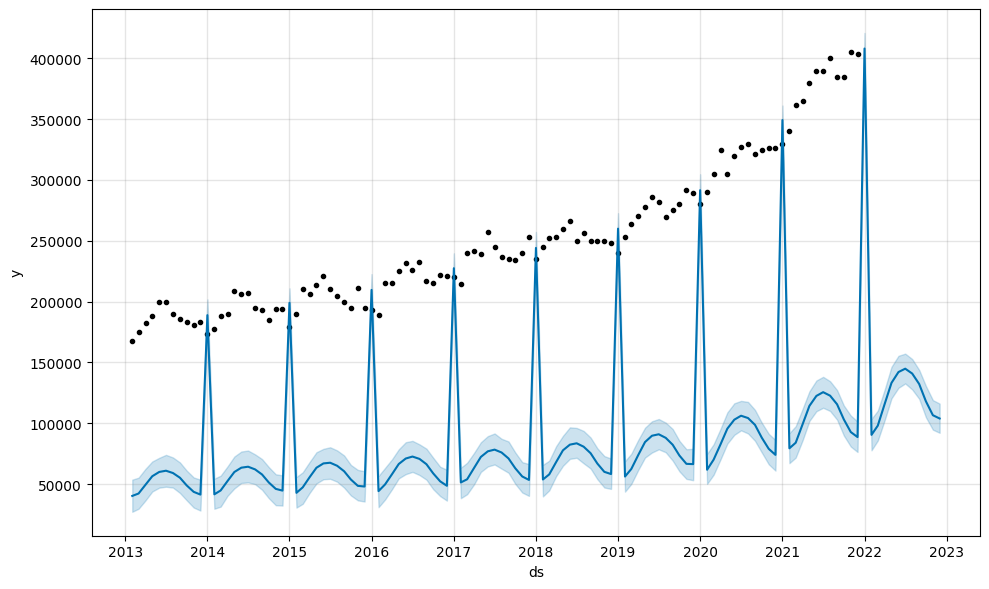

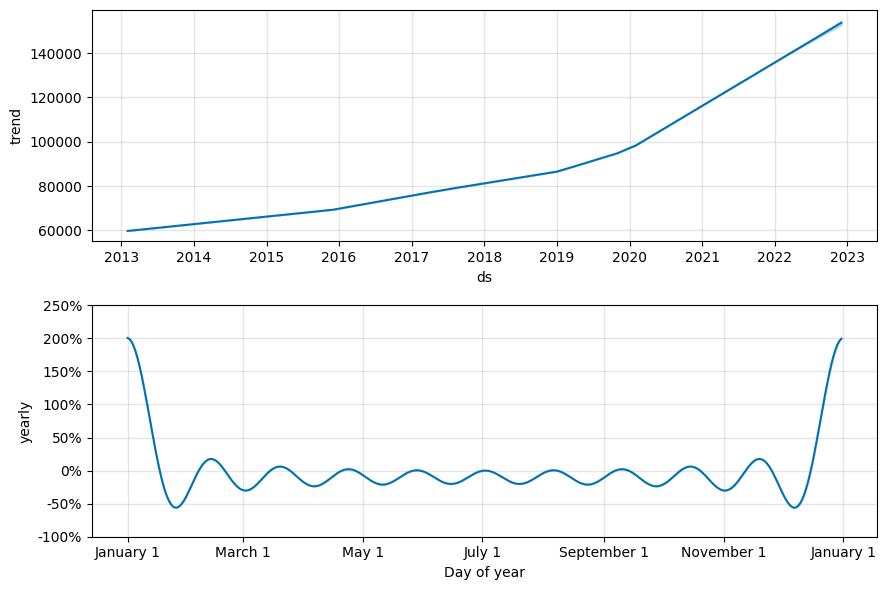

In [114]:
from prophet import Prophet
prophet_df = meck_sfr.select(['period_begin', 'median_sale_price']).to_pandas()
prophet_df.columns = ['ds', 'y']

print(f"Data shape: {prophet_df.shape}")
print(prophet_df.head())

# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Monthly data, no weekly pattern
    daily_seasonality=False,   # Monthly data, no daily pattern
    seasonality_mode='multiplicative'  # Real estate often has multiplicative seasonality
)

model.fit(prophet_df)

print("✓ Prophet model trained!")

# Make future dataframe for forecasting (12 months ahead)
future = model.make_future_dataframe(periods=12, freq='MS')  # MS = month start
forecast = model.predict(future)

# Show forecast
print("\nForecast for next 12 months:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

# Plot forecast
fig1 = model.plot(forecast)
fig1.show()

# Plot components (trend + seasonality)
fig2 = model.plot_components(forecast)
fig2.show()

22:47:20 - cmdstanpy - INFO - Chain [1] start processing
22:47:20 - cmdstanpy - INFO - Chain [1] done processing



Forecast for next 12 months:
            ds           yhat     yhat_lower     yhat_upper
107 2022-01-01  394328.192289  380389.328256  407534.347902
108 2022-02-01  397814.670841  384228.460169  411288.030102
109 2022-03-01  401099.767195  388163.567315  414777.312822
110 2022-04-01  408768.393333  396108.451747  422651.716707
111 2022-05-01  411538.549861  398212.175791  424764.483066
112 2022-06-01  414869.044067  401424.874820  427152.451521
113 2022-07-01  422595.025963  408445.819769  435911.157020
114 2022-08-01  425133.228670  411557.727633  438371.480013
115 2022-09-01  428709.242793  415242.038521  442280.029702
116 2022-10-01  435740.560902  422491.902285  448992.702406
117 2022-11-01  438760.508546  425288.621364  452141.955506
118 2022-12-01  442290.991069  429410.476625  456342.119839


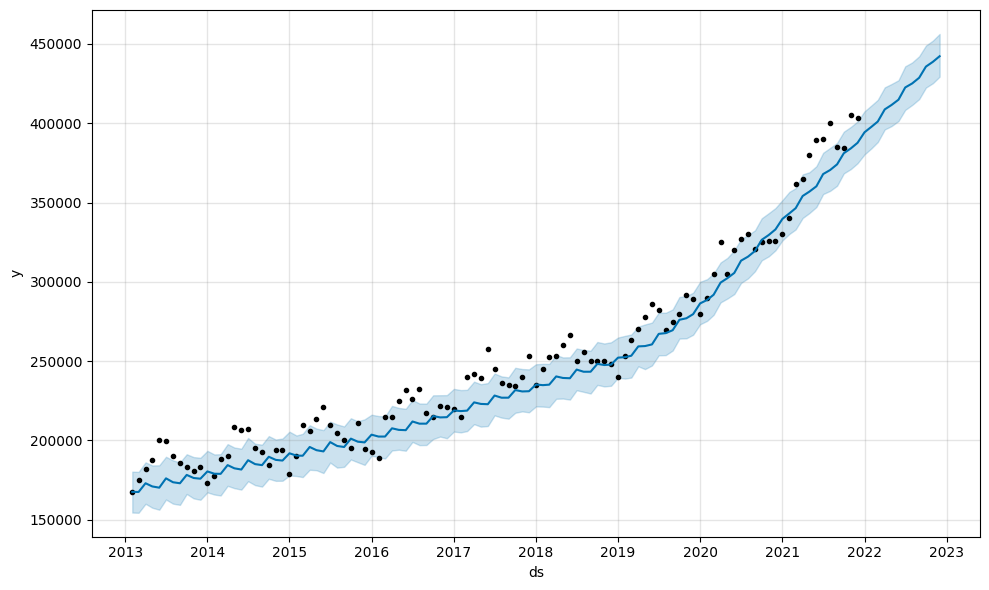

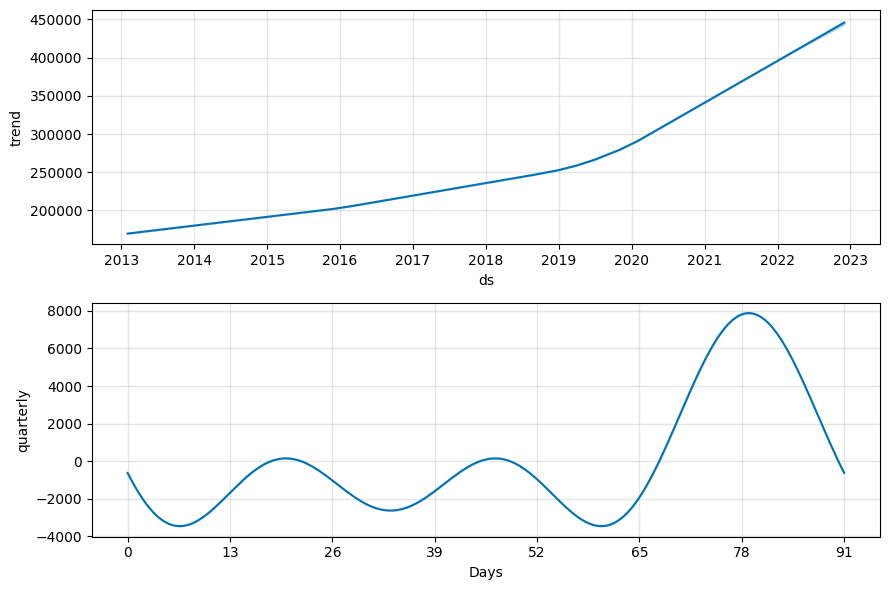

In [115]:
model = Prophet(
    yearly_seasonality=False,  # Turn off - not enough monthly obs per year
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',  # Additive instead of multiplicative
    changepoint_prior_scale=0.05,  # Less flexible to avoid overfitting
)

# Add custom seasonality for quarterly patterns (common in real estate)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)

model.fit(prophet_df)

# Forecast
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

print("\nForecast for next 12 months:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

# Plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [116]:
# Test on last 12 months
train_df = prophet_df[:-12]
test_df = prophet_df[-12:]

# 1. Prophet
prophet_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
prophet_model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
prophet_model.fit(train_df) 

prophet_forecast = prophet_model.predict(test_df[['ds']])
prophet_pred = prophet_forecast['yhat'].values

# 2. ARIMA
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train_df['y'], order=(0, 1, 1))
arima_results = arima_model.fit()
arima_pred = arima_results.forecast(steps=12)

# 3. Compare
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = test_df['y'].values

print("Prophet:")
print(f"  MAE: ${mean_absolute_error(y_true, prophet_pred):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_true, prophet_pred)):,.0f}")
print(f"  R²: {r2_score(y_true, prophet_pred):.3f}")

print("\nARIMA(0,1,1):")
print(f"  MAE: ${mean_absolute_error(y_true, arima_pred):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_true, arima_pred)):,.0f}")
print(f"  R²: {r2_score(y_true, arima_pred):.3f}")

22:49:16 - cmdstanpy - INFO - Chain [1] start processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet:
  MAE: $30,419
  RMSE: $33,581
  R²: -1.106

ARIMA(0,1,1):
  MAE: $51,956
  RMSE: $56,876
  R²: -5.041


In [117]:
# Define COVID period                                                                                                
covid_start = pd.to_datetime('2020-03-01')                                                                           
                                                                                                                    
# Filter out COVID period for training                                                                               
pre_covid_df = prophet_df[prophet_df['ds'] < covid_start].copy()                                                     
                                                                                                                    
print(f"Original data: {len(prophet_df)} months")                                                                    
print(f"Pre-COVID data: {len(pre_covid_df)} months")                                                                 
print(f"Date range: {pre_covid_df['ds'].min()} to {pre_covid_df['ds'].max()}")                                       
                                                                                                                    
# Train/test split (pre-COVID only)                                                                                  
train_size = int(len(pre_covid_df) * 0.8)
train_df = pre_covid_df[:train_size]
test_df = pre_covid_df[train_size:]

# Train Prophet on pre-COVID data
model_pre_covid = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
model_pre_covid.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
model_pre_covid.fit(train_df)

# Predict on pre-COVID test set
forecast = model_pre_covid.predict(test_df[['ds']])

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = test_df['y'].values
y_pred = forecast['yhat'].values

print("\nPre-COVID Model Performance:")
print(f"  MAE: ${mean_absolute_error(y_true, y_pred):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_true, y_pred)):,.0f}")
print(f"  R²: {r2_score(y_true, y_pred):.3f}")

22:52:52 - cmdstanpy - INFO - Chain [1] start processing
22:52:52 - cmdstanpy - INFO - Chain [1] done processing


Original data: 107 months
Pre-COVID data: 85 months
Date range: 2013-02-01 00:00:00 to 2020-02-01 00:00:00

Pre-COVID Model Performance:
  MAE: $8,696
  RMSE: $10,524
  R²: 0.577


In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Add COVID indicator to full dataset
covid_start = pd.to_datetime('2020-03-01')
prophet_df_full = prophet_df.copy()
prophet_df_full['covid_period'] = (prophet_df_full['ds'] >= covid_start).astype(int)

# Train/test split (last 12 months for testing)
train_df = prophet_df_full[:-12].copy()
test_df = prophet_df_full[-12:].copy()

print(f"Training data: {len(train_df)} months")
print(f"Test data: {len(test_df)} months")
print(f"COVID months in training: {train_df['covid_period'].sum()}")
print(f"COVID months in test: {test_df['covid_period'].sum()}")

# Build Prophet model with COVID regressor
model_covid = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
model_covid.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
model_covid.add_regressor('covid_period')  # Key addition!

# Fit model
model_covid.fit(train_df[['ds', 'y', 'covid_period']])

# Predict on test set
forecast = model_covid.predict(test_df[['ds', 'covid_period']])

# Evaluate
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

print("\nCOVID-Aware Model Performance:")
print(f"  MAE: ${mean_absolute_error(y_true, y_pred):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_true, y_pred)):,.0f}")
print(f"  R²: {r2_score(y_true, y_pred):.3f}")

# Compare to previous models
print("\n=== Comparison ===")
print("Pre-COVID only:  MAE=$8,696   R²=0.577  (but old data)")
print("Full data basic: MAE=$30,419  R²=-1.106 (bad)")
print(f"COVID regressor: MAE=${mean_absolute_error(y_true, y_pred):,.0f}   R²={r2_score(y_true, y_pred):.3f}")

22:58:38 - cmdstanpy - INFO - Chain [1] start processing
22:58:39 - cmdstanpy - INFO - Chain [1] done processing


Training data: 95 months
Test data: 12 months
COVID months in training: 10
COVID months in test: 12

COVID-Aware Model Performance:
  MAE: $40,360
  RMSE: $44,463
  R²: -2.692

=== Comparison ===
Pre-COVID only:  MAE=$8,696   R²=0.577  (but old data)
Full data basic: MAE=$30,419  R²=-1.106 (bad)
COVID regressor: MAE=$40,360   R²=-2.692


In [120]:
# Use only post-COVID data (last ~3 years)
recent_start = pd.to_datetime('2020-03-01')
recent_df = prophet_df[prophet_df['ds'] >= recent_start].copy()

print(f"Recent data: {len(recent_df)} months")

# Need at least 24 months, so check
if len(recent_df) >= 24:
    train_size = int(len(recent_df) * 0.75)
    train_df = recent_df[:train_size]
    test_df = recent_df[train_size:]

    model_recent = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.1  # More flexible for volatile period
    )
    model_recent.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
    model_recent.fit(train_df)

    forecast = model_recent.predict(test_df[['ds']])

    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values

    print(f"\nRecent Data Model (post-COVID only):")
    print(f"  MAE: ${mean_absolute_error(y_true, y_pred):,.0f}")
    print(f"  RMSE: ${np.sqrt(mean_squared_error(y_true, y_pred)):,.0f}")
    print(f"  R²: {r2_score(y_true, y_pred):.3f}")
else:
    print(f"Not enough data: {len(recent_df)} months")

Recent data: 22 months
Not enough data: 22 months


In [121]:
# Aggregate all property types for Mecklenburg County
meck_all_props = meck_data.group_by('period_begin').agg([
    pl.col('median_sale_price').mean().alias('median_sale_price'),
    pl.col('median_sale_price').count().alias('n_properties')
]).sort('period_begin')

# Convert to Prophet format
prophet_df_all = meck_all_props.select(['period_begin', 'median_sale_price']).to_pandas()
prophet_df_all.columns = ['ds', 'y']

print(f"Total observations: {len(prophet_df_all)}")

Total observations: 107


In [123]:
# Filter to Single Family Residential across all counties                                                            
sfr_all_counties = county_df_clean.filter(                                                                           
    pl.col('property_type') == 'Single Family Residential'                                                           
).sort(['region', 'period_begin'])                                                                      
                                                                                                                    
# Get counties with enough data (at least 36 months)                                                                 
county_counts = sfr_all_counties.group_by('region').agg(                                                
    pl.col('median_sale_price').count().alias('n_obs')                                                               
).filter(pl.col('n_obs') >= 36).sort('n_obs', descending=True)                                                       
                                                                                                                    
print(f"Counties with 36+ months: {len(county_counts)}")                                                             
print(county_counts.head(10))                                                                                        
                                                                                                                    
# Train model for each county                                                                                        
results = []                                                                                                         
for county in county_counts['region'][:5]:  # Try top 5 first                                           
    county_data = sfr_all_counties.filter(                                                                           
        pl.col('region') == county                                                                      
    ).select(['period_begin', 'median_sale_price']).to_pandas()                                                      
    county_data.columns = ['ds', 'y']                                                                                

    # Train/test split
    train_df = county_data[:-12]
    test_df = county_data[-12:]

    # Train Prophet
    model = Prophet(
        yearly_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05
    )
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
    model.fit(train_df)

    # Evaluate
    forecast = model.predict(test_df[['ds']])
    mae = mean_absolute_error(test_df['y'], forecast['yhat'])
    r2 = r2_score(test_df['y'], forecast['yhat'])

    results.append({
        'county': county,
        'n_obs': len(county_data),
        'mae': mae,
        'r2': r2
    })
    print(f"{county}: MAE=${mae:,.0f}, R²={r2:.3f}")

# Summary
results_df = pl.DataFrame(results)
print("\n", results_df)

23:03:31 - cmdstanpy - INFO - Chain [1] start processing
23:03:31 - cmdstanpy - INFO - Chain [1] done processing
23:03:31 - cmdstanpy - INFO - Chain [1] start processing
23:03:31 - cmdstanpy - INFO - Chain [1] done processing
23:03:31 - cmdstanpy - INFO - Chain [1] start processing
23:03:31 - cmdstanpy - INFO - Chain [1] done processing
23:03:31 - cmdstanpy - INFO - Chain [1] start processing
23:03:31 - cmdstanpy - INFO - Chain [1] done processing
23:03:31 - cmdstanpy - INFO - Chain [1] start processing
23:03:31 - cmdstanpy - INFO - Chain [1] done processing


Counties with 36+ months: 1489
shape: (10, 2)
┌───────────────────────┬───────┐
│ region                ┆ n_obs │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ Adams County, PA      ┆ 120   │
│ Addison County, VT    ┆ 120   │
│ Alachua County, FL    ┆ 120   │
│ Alamance County, NC   ┆ 120   │
│ Albany County, NY     ┆ 120   │
│ Allegan County, MI    ┆ 120   │
│ Allegheny County, PA  ┆ 120   │
│ Anchorage Borough, AK ┆ 120   │
│ Anderson County, SC   ┆ 120   │
│ Anderson County, TN   ┆ 120   │
└───────────────────────┴───────┘
Adams County, PA: MAE=$22,280, R²=-2.642
Addison County, VT: MAE=$51,572, R²=-2.067
Alachua County, FL: MAE=$27,050, R²=-2.327
Alamance County, NC: MAE=$18,435, R²=-0.660
Albany County, NY: MAE=$25,847, R²=-1.414

 shape: (5, 4)
┌─────────────────────┬───────┬──────────────┬───────────┐
│ county              ┆ n_obs ┆ mae          ┆ r2        │
│ ---                 ┆ ---   ┆ ---          ┆ ---       │
│ st

In [125]:
# Use all counties together
sfr_all = sfr_all_counties.with_columns([
    pl.col('region').cast(pl.Categorical).to_physical().alias('county_id')
])

prophet_df_multi = sfr_all.select([
    'period_begin', 'median_sale_price', 'county_id'
]).to_pandas()
prophet_df_multi.columns = ['ds', 'y', 'county_id']

# Train pooled model
model_pooled = Prophet()
model_pooled.add_regressor('county_id')
model_pooled.fit(prophet_df_multi)

23:09:12 - cmdstanpy - INFO - Chain [1] start processing
23:09:20 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
# Filter SFR across all regions                                                                                      
sfr_all = county_df_clean.filter(                                                                                    
    pl.col('property_type') == 'Single Family Residential'                                                           
)                                                                                                                    
                                                                                                                    
# Encode region as numeric for Prophet regressor                                                                     
sfr_encoded = sfr_all.with_columns([                                                                                 
    pl.col('region').cast(pl.Categorical).to_physical().alias('region_id')                                           
]).select(['period_begin', 'median_sale_price', 'region_id'])                                                        
                                                                                                                    
prophet_df = sfr_encoded.to_pandas()                                                                                 
prophet_df.columns = ['ds', 'y', 'region_id']                                                                        
                                                                                                                    
# Train/test                                                                                                         
train_df = prophet_df[:-1000]  # Hold out some for testing                                                           
test_df = prophet_df[-1000:]                                                                                         
                                                                                                                    
model = Prophet(changepoint_prior_scale=0.05)                                                                        
model.add_regressor('region_id')                                                                                     
model.fit(train_df)                                                                                                  
                                                                                                                    
forecast = model.predict(test_df[['ds', 'region_id']])                                                               
print(f"MAE: ${mean_absolute_error(test_df['y'], forecast['yhat']):,.0f}")                                           
print(f"R²: {r2_score(test_df['y'], forecast['yhat']):.3f}") 

23:11:09 - cmdstanpy - INFO - Chain [1] start processing
23:11:17 - cmdstanpy - INFO - Chain [1] done processing


MAE: $64,816
R²: -0.107


In [130]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

Train: 76, Test: 19
Using device: cuda
Model: LSTMModel(
  (lstm): LSTM(1, 100, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=100, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch [10/200], Loss: 0.048795
Epoch [20/200], Loss: 0.041780
Epoch [30/200], Loss: 0.005565
Epoch [40/200], Loss: 0.002098
Epoch [50/200], Loss: 0.002478
Epoch [60/200], Loss: 0.001253
Epoch [70/200], Loss: 0.003054
Epoch [80/200], Loss: 0.002408
Epoch [90/200], Loss: 0.001378
Epoch [100/200], Loss: 0.001282
Epoch [110/200], Loss: 0.002375
Epoch [120/200], Loss: 0.001086
Epoch [130/200], Loss: 0.001153
Epoch [140/200], Loss: 0.001826
Epoch [150/200], Loss: 0.001082
Epoch [160/200], Loss: 0.001806
Epoch [170/200], Loss: 0.000980
Epoch [180/200], Loss: 0.002722
Epoch [190/200], Loss: 0.001140
Epoch [200/200], Loss: 0.001452

=== LSTM Performance ===
MAE: $19,594
RMSE: $23,850
R²: 0.427


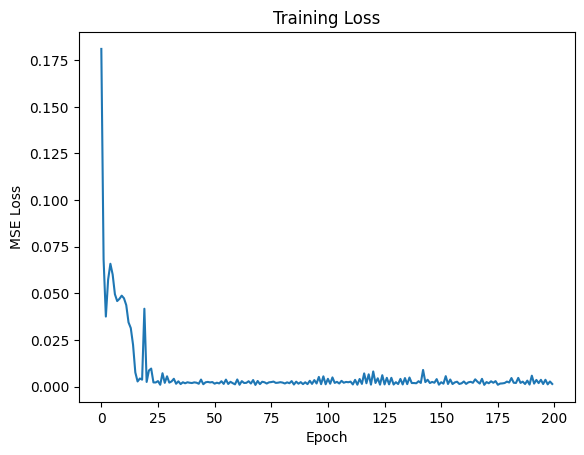

In [132]:
# Prepare data                                                                                                         
meck_sfr = county_df_clean.filter(                                                                                   
    (pl.col('region') == 'Mecklenburg County, NC') &                                                                 
    (pl.col('property_type') == 'Single Family Residential')                                                         
).sort('period_begin')                                                                                               
                                                                                                                    
prices = meck_sfr['median_sale_price'].to_numpy().reshape(-1, 1)                                                     
                                                                                                                    
# Scale data                                                                                                         
scaler = MinMaxScaler()                                                                                              
prices_scaled = scaler.fit_transform(prices)                                                                         
                                                                                                                    
# Create sequences                                                                                                   
def create_sequences(data, seq_length=12):                                                                           
    X, y = [], []                                                                                                    
    for i in range(len(data) - seq_length):                                                                          
        X.append(data[i:i+seq_length])                                                                               
        y.append(data[i+seq_length])                                                                                 
    return np.array(X), np.array(y)                                                                                  
                                                                                                                    
seq_length = 12                                                                                                      
X, y = create_sequences(prices_scaled, seq_length)                                                                   
                                                                                                                    
# Train/test split                                                                                                   
split = int(0.8 * len(X))                                                                                            
X_train = torch.FloatTensor(X[:split])                                                                               
y_train = torch.FloatTensor(y[:split])                                                                               
X_test = torch.FloatTensor(X[split:])
y_test = torch.FloatTensor(y[split:])                                                                                
                                                                                                                    
print(f"Train: {len(X_train)}, Test: {len(X_test)}")    

#Define LSTM Model                                                                                                  
class LSTMModel(nn.Module):                                                                                          
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):                                     
        super(LSTMModel, self).__init__()                                                                            
        self.hidden_size = hidden_size                                                                               
        self.num_layers = num_layers                                                                                 
                                                                                                                    
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,                                                     
                            batch_first=True, dropout=dropout)                                                        
        self.fc1 = nn.Linear(hidden_size, 25)                                                                        
        self.fc2 = nn.Linear(25, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # LSTM output
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last time step
        out = self.relu(self.fc1(out))
        out = self.fc2(out) 
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(
    input_size=1,
    hidden_size=100,
    num_layers=3,
    dropout=0.3
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Using device: {device}")
print(f"Model: {model}")

# Training
epochs = 200
batch_size = 16

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

train_losses = []
for epoch in range(epochs):
    model.train()

    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

# Evaluate
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test).cpu().numpy()
    y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())
    y_pred = scaler.inverse_transform(y_pred_scaled)

print(f"\n=== LSTM Performance ===")
print(f"MAE: ${mean_absolute_error(y_test_actual, y_pred):,.0f}")
print(f"RMSE: ${np.sqrt(np.mean((y_test_actual - y_pred)**2)):,.0f}")
print(f"R²: {r2_score(y_test_actual, y_pred):.3f}")

# Plot losses
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [133]:
# Use ALL available features, not just price                                                                         
feature_cols = [                                                                                                     
    'median_sale_price',                                                                                             
    'homes_sold',                                                                                                    
    'inventory',                                                                                                     
    'median_dom',  # days on market                                                                                  
    'avg_sale_to_list'                                                                                               
]                                                                                                                    
                                                                                                                    
# Prepare multivariate data                                                                                          
meck_sfr_features = county_df_clean.filter(                                                                          
    (pl.col('region') == 'Mecklenburg County, NC') &                                                                 
    (pl.col('property_type') == 'Single Family Residential')                                                         
).sort('period_begin').select(feature_cols)                                                                          
                                                                                                                    
# Check what columns exist                                                                                           
print("Available columns:", meck_sfr_features.columns)                                                               
                                                                                                                    
data = meck_sfr_features.to_numpy()                                                                                  
                                                                                                                    
# Scale each feature                                                                                                 
scaler = MinMaxScaler()                                                                                              
data_scaled = scaler.fit_transform(data)                                                                             
                                                                                                                    
# Create sequences (now multi-dimensional)                                                                           
def create_sequences(data, seq_length=12):                                                                           
    X, y = [], []                                                                                                    
    for i in range(len(data) - seq_length):                                                                          
        X.append(data[i:i+seq_length, :])  # All features                                                            
        y.append(data[i+seq_length, 0])    # Predict only price                                                      
    return np.array(X), np.array(y)                                                                                  
                                                                                                                    
X, y = create_sequences(data_scaled, seq_length=12)                                                                  
                                                                                                                    
# Update model for multiple input features                                                                           
class MultivariateLSTM(nn.Module):                                                                                   
    def __init__(self, input_size=5, hidden_size=100, num_layers=3):                                                 
        super(MultivariateLSTM, self).__init__()                                                                     
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,                                                     
                            batch_first=True, dropout=0.3)                                                            
        self.fc1 = nn.Linear(hidden_size, 50)                                                                        
        self.fc2 = nn.Linear(50, 1)                                                                                  
        self.relu = nn.ReLU()                                                                                        
                                                                                                                    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.fc2(out) 
        return out

model = MultivariateLSTM(input_size=len(feature_cols))

Available columns: ['median_sale_price', 'homes_sold', 'inventory', 'median_dom', 'avg_sale_to_list']


In [134]:
# Check available columns in your dataset                                                                            
print("Available columns:")                                                                                          
print(county_df_clean.columns)                                                                                       
                                                                                                                    
# Check data for Mecklenburg SFR                                                                                     
meck_sfr_check = county_df_clean.filter(                                                                             
    (pl.col('region') == 'Mecklenburg County, NC') &                                                                 
    (pl.col('property_type') == 'Single Family Residential')                                                         
).sort('period_begin')                                                                                               
                                                                                                                    
print("\nSample data:")                                                                                              
print(meck_sfr_check.head())                                                                                         
print(f"\nShape: {meck_sfr_check.shape}")

Available columns:
['period_begin', 'period_end', 'region', 'state_code', 'property_type', 'median_sale_price', 'median_sale_price_mom', 'median_sale_price_yoy', 'median_list_price', 'median_ppsf', 'homes_sold', 'homes_sold_mom', 'homes_sold_yoy', 'pending_sales', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings', 'new_listings_mom', 'new_listings_yoy', 'inventory', 'inventory_mom', 'inventory_yoy', 'months_of_supply', 'months_of_supply_mom', 'months_of_supply_yoy', 'median_dom', 'median_dom_mom', 'median_dom_yoy', 'avg_sale_to_list', 'sold_above_list', 'price_drops', 'price_drops_mom', 'price_drops_yoy', 'off_market_in_two_weeks']

Sample data:
shape: (5, 34)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ period_be ┆ period_en ┆ region    ┆ state_cod ┆ … ┆ price_dro ┆ price_dro ┆ price_dro ┆ off_mark │
│ gin       ┆ d         ┆ ---       ┆ e         ┆   ┆ ps        ┆ ps_mom    ┆ ps_yoy    ┆ et_in_tw │
│ ---       ┆ ---    

In [135]:
# Select features (adjust based on your available columns)                                                           
feature_cols = [                                                                                                     
    'median_sale_price',   # Target (also used as feature)                                                           
    'homes_sold',          # Volume indicator                                                                        
    'inventory',           # Supply indicator                                                                        
    'median_dom',          # Market speed                                                                            
    'avg_sale_to_list',    # Pricing power                                                                           
    'median_ppsf'          # Price per sqft                                                                          
]                                                                                                                    
                                                                                                                    
# Filter available columns                                                                                           
meck_sfr_all = county_df_clean.filter(                                                                               
    (pl.col('region') == 'Mecklenburg County, NC') &                                                                 
    (pl.col('property_type') == 'Single Family Residential')                                                         
).sort('period_begin')                                                                                               
                                                                                                                    
# Select only columns that exist                                                                                     
available_features = [col for col in feature_cols if col in meck_sfr_all.columns]                                    
print(f"Using features: {available_features}")                                                                       
                                                                                                                    
# Extract data                                                                                                       
meck_features = meck_sfr_all.select(available_features).drop_nulls()                                                 
data = meck_features.to_numpy()                                                                                      
                                                                                                                    
print(f"Data shape: {data.shape}")                                                                                   
print(f"Features: {len(available_features)}")                                                                        
                                                                                                                    
# Scale each feature independently                                                                                   
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Save target scaler for inverse transform later
target_scaler = MinMaxScaler()
target_scaler.fit(data[:, 0].reshape(-1, 1))  # Assuming first column is median_sale_price

# Create sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])  # All features for sequence
        y.append(data[i+seq_length, 0])     # Predict only price (first column)
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(data_scaled, seq_length)

# Train/test split
split = int(0.8 * len(X))
X_train = torch.FloatTensor(X[:split])
y_train = torch.FloatTensor(y[:split])
X_test = torch.FloatTensor(X[split:])
y_test = torch.FloatTensor(y[split:])

print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Input shape: {X_train.shape}")  # Should be (samples, seq_length, n_features)

Using features: ['median_sale_price', 'homes_sold', 'inventory', 'median_dom', 'avg_sale_to_list', 'median_ppsf']
Data shape: (107, 6)
Features: 6
Train: 76, Test: 19
Input shape: torch.Size([76, 12, 6])


In [136]:
# Multivariate LSTM Model                                                                          23:22:14 [65/1994]
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0.3):
        super(MultivariateLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc1 = nn.Linear(hidden_size, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last time step

        # Fully connected layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.fc3(out) 
        return out

# Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_features = len(available_features)

model = MultivariateLSTM(
    input_size=n_features,
    hidden_size=100,
    num_layers=3,
    dropout=0.3
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\nModel architecture:")
print(model)
print(f"Using device: {device}")

# Move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


Model architecture:
MultivariateLSTM(
  (lstm): LSTM(6, 100, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Using device: cuda


In [137]:
# Training                                                                                          23:22:14 [9/1994]
epochs = 150
batch_size = 16

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Forward
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs.squeeze(), y_test)
        val_losses.append(val_loss.item())

    train_losses.append(epoch_loss / (len(X_train) // batch_size))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}')

# Evaluate
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test).cpu().numpy()

# Inverse transform
y_test_actual = target_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled)

print(f"\n{'='*50}")
print(f"MULTIVARIATE LSTM PERFORMANCE")
print(f"{'='*50}")
print(f"Features used: {n_features}")
print(f"MAE: ${mean_absolute_error(y_test_actual, y_pred):,.0f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_pred)):,.0f}")
print(f"R²: {r2_score(y_test_actual, y_pred):.3f}")
print(f"\nPrevious (univariate):")
print(f"MAE: $19,000, RMSE: $23,850, R²: 0.427")

Epoch [10/150], Train Loss: 0.021939, Val Loss: 0.156005
Epoch [20/150], Train Loss: 0.006973, Val Loss: 0.144120
Epoch [30/150], Train Loss: 0.004401, Val Loss: 0.083215
Epoch [40/150], Train Loss: 0.004276, Val Loss: 0.042107
Epoch [50/150], Train Loss: 0.003909, Val Loss: 0.030654
Epoch [60/150], Train Loss: 0.004539, Val Loss: 0.029461
Epoch [70/150], Train Loss: 0.002981, Val Loss: 0.039215
Epoch [80/150], Train Loss: 0.002701, Val Loss: 0.023483
Epoch [90/150], Train Loss: 0.002777, Val Loss: 0.034190
Epoch [100/150], Train Loss: 0.005475, Val Loss: 0.032447
Epoch [110/150], Train Loss: 0.002099, Val Loss: 0.040588
Epoch [120/150], Train Loss: 0.001930, Val Loss: 0.052725
Epoch [130/150], Train Loss: 0.002054, Val Loss: 0.050377
Epoch [140/150], Train Loss: 0.001616, Val Loss: 0.063410
Epoch [150/150], Train Loss: 0.001485, Val Loss: 0.061585

MULTIVARIATE LSTM PERFORMANCE
Features used: 6
MAE: $51,100
RMSE: $59,072
R²: -2.515

Previous (univariate):
MAE: $19,000, RMSE: $23,850, 

Original data points: 107
After drop_nulls: 107
Data lost: 0 rows

Null counts per column:
shape: (1, 6)
┌───────────────────┬────────────┬───────────┬────────────┬──────────────────┬─────────────┐
│ median_sale_price ┆ homes_sold ┆ inventory ┆ median_dom ┆ avg_sale_to_list ┆ median_ppsf │
│ ---               ┆ ---        ┆ ---       ┆ ---        ┆ ---              ┆ ---         │
│ u32               ┆ u32        ┆ u32       ┆ u32        ┆ u32              ┆ u32         │
╞═══════════════════╪════════════╪═══════════╪════════════╪══════════════════╪═════════════╡
│ 0                 ┆ 0          ┆ 0         ┆ 0          ┆ 0                ┆ 0           │
└───────────────────┴────────────┴───────────┴────────────┴──────────────────┴─────────────┘

Data statistics:
shape: (9, 7)
┌────────────┬───────────────┬─────────────┬─────────────┬────────────┬──────────────┬─────────────┐
│ statistic  ┆ median_sale_p ┆ homes_sold  ┆ inventory   ┆ median_dom ┆ avg_sale_to_ ┆ median_ppsf │
│ ---     

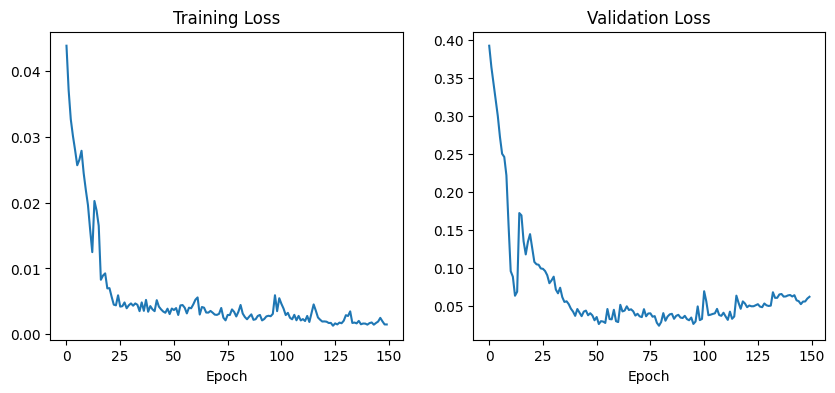

In [139]:
# Check how much data you lost                                                                     23:25:06 [39/1890]
print(f"Original data points: {len(meck_sfr_all)}")                                                                  
print(f"After drop_nulls: {len(meck_features)}")                                                                     
print(f"Data lost: {len(meck_sfr_all) - len(meck_features)} rows")                                                   
                                                                                                                    
# Check for NaN issues                                                                                               
print("\nNull counts per column:")                                                                                   
print(meck_sfr_all.select(available_features).null_count())                                                          
                                                                                                                    
# Check data distribution                                                                                            
print("\nData statistics:")                                                                                          
print(meck_features.describe())                                                                                      
                                                                                                                    
# Step 2: Start Simpler - Use Only 2-3 Best Features                                                                   
                                                                                                                    
# Try minimal feature set first                                                                                      
simple_features = ['median_sale_price', 'homes_sold']  # Start with just 2                                           
                                                                                                                    
meck_simple = meck_sfr_all.select(simple_features).drop_nulls()                                                      
data = meck_simple.to_numpy()                                                                                        
                                                                                                                    
print(f"Simple features data shape: {data.shape}")                                                                   
                                                                                                                    
# Same LSTM code but with input_size=2                                                                               
model = MultivariateLSTM(                                                                                            
    input_size=2,  # Only 2 features                                                                                 
    hidden_size=50,  # Smaller model                                                                                 
    num_layers=2,    # Fewer layers                                                                                  
    dropout=0.2                                                                                                      
).to(device)                                                                                                         
                                                                                                                    
# Step 3: Check Training Curves                                                                                        
                                                                                                                    
# After training, plot losses                                                                                        
import matplotlib.pyplot as plt                                                                                      
                                                                                                                    
plt.figure(figsize=(10, 4))                                                                                          
plt.subplot(1, 2, 1)                                                                                                 
plt.plot(train_losses)                                                                                               
plt.title('Training Loss')                                                                                           
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.show()

# If val_loss is increasing while train_loss decreases = overfitting
# If both are high = underfitting
# If both are decreasing = good!

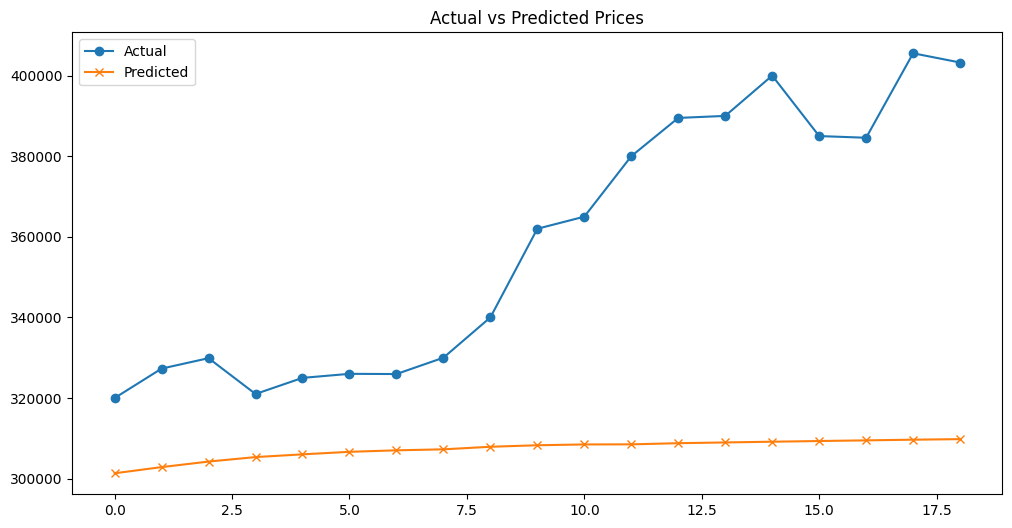

Prediction range: $301,327 to $309,798
Actual range: $320,000 to $405,539


In [140]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

# Check if predictions are constant or way off
print(f"Prediction range: ${y_pred.min():,.0f} to ${y_pred.max():,.0f}")
print(f"Actual range: ${y_test_actual.min():,.0f} to ${y_test_actual.max():,.0f}")

In [142]:
# Transform to predict changes (makes it stationary)                                                                 
def create_sequences_diff(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:i+seq_length, :])
        # Predict the CHANGE, not absolute price
        y.append(data[i+seq_length+1, 0] - data[i+seq_length, 0])
    return np.array(X), np.array(y)

# Then reconstruct predictions:
# predicted_price = last_known_price + predicted_change

# Fix 2: Use Different Loss Function (Huber Loss)

# Replace MSE with Huber loss (more robust)
criterion = nn.HuberLoss(delta=1.0)  # Less sensitive to outliers

# Fix 3: Just Use Price + Time Features (Simpler)

# Create time-based features instead of other variables
meck_enhanced = meck_sfr_all.with_columns([
    # Lag features
    pl.col('median_sale_price').shift(1).alias('price_lag1'),
    pl.col('median_sale_price').shift(3).alias('price_lag3'),

    # Rolling mean
    pl.col('median_sale_price').rolling_mean(window_size=3).alias('price_ma3'),

    # Time index (captures trend)
    pl.lit(range(len(meck_sfr_all))).alias('time_idx')
]).drop_nulls()

features = ['median_sale_price', 'price_lag1', 'price_lag3', 'price_ma3', 'time_idx']

# Fix 4: Go Back to Univariate (Was Working!)

# Since univariate gave you R²=0.427, and multivariate is worse, stick with univariate but optimize it:

# Just price, but with better architecture
model = MultivariateLSTM(
    input_size=1,
    hidden_size=128,  # Bigger
    num_layers=4,     # Deeper
    dropout=0.2
)

# Try longer training
epochs = 200

In [143]:
class MarketTimingModel:                                                                                             
    def __init__(self, lstm_model, scaler):                                                                          
        self.model = lstm_model                                                                                      
        self.scaler = scaler                                                                                         
                                                                                                                    
    def forecast_returns(self, data, periods=12):                                                                    
        """Forecast future prices and calculate expected returns"""                                                  
        # Get last sequence                                                                                          
        last_seq = data[-12:].reshape(1, 12, 1)                                                                      
        last_seq_scaled = self.scaler.transform(last_seq.reshape(-1, 1)).reshape(1, 12, 1)                           
                                                                                                                    
        # Predict next period                                                                                        
        predictions = []                                                                                             
        current_seq = torch.FloatTensor(last_seq_scaled).to('cuda')                                                  
                                                                                                                    
        for _ in range(periods):                                                                                     
            with torch.no_grad():                                                                                    
                pred = self.model(current_seq).cpu().numpy()                                                         
                predictions.append(pred[0, 0])                                                                       
                                                                                                                    
                # Update sequence for next prediction                                                                
                current_seq = torch.cat([                                                                            
                    current_seq[:, 1:, :],                                                                           
                    torch.FloatTensor(pred).reshape(1, 1, 1).to('cuda')                                              
                ], dim=1)                                                                                            
                                                                                                                    
        # Inverse transform                                                                                          
        predictions_actual = self.scaler.inverse_transform(                                                          
            np.array(predictions).reshape(-1, 1)                                                                     
        ).flatten()                                                                                                  
                                                                                                                    
        # Calculate metrics                                                                                          
        current_price = data[-1]                                                                                     
        future_price = predictions_actual[-1]                                                                        
        expected_return = (future_price - current_price) / current_price                                             
                                                                                                                    
        return {                                                                                                     
            'current_price': current_price,                                                                          
            'forecast_12m': future_price,
            'expected_return': expected_return,
            'predictions': predictions_actual
        }

    def generate_signal(self, expected_return, threshold=0.05):
        """Generate buy/sell/hold signal"""
        if expected_return > threshold:
            return 'BUY', expected_return
        elif expected_return < -threshold:
            return 'SELL', expected_return
        else:
            return 'HOLD', expected_return

In [144]:
class RiskStratifier:
    def __init__(self):
        pass

    def calculate_risk_metrics(self, historical_data, predictions, actual_test=None):
        """Calculate comprehensive risk metrics"""

        # 1. Price Volatility (historical)
        returns = np.diff(historical_data) / historical_data[:-1]
        volatility = np.std(returns) * np.sqrt(12)  # Annualized

        # 2. Prediction Uncertainty
        if actual_test is not None:
            prediction_error = np.std(actual_test - predictions)
            forecast_accuracy = 1 - (np.mean(np.abs(actual_test - predictions)) / np.mean(actual_test))
        else:
            prediction_error = None
            forecast_accuracy = None

        # 3. Trend Stability (how consistent is the trend)
        trend = np.polyfit(range(len(historical_data)), historical_data, 1)[0]
        detrended = historical_data - (trend * np.arange(len(historical_data)))
        trend_stability = 1 - (np.std(detrended) / np.mean(historical_data))

        return {
            'volatility': volatility,
            'prediction_error': prediction_error,
            'forecast_accuracy': forecast_accuracy,
            'trend_stability': trend_stability
        }

    def stratify_risk(self, risk_metrics):
        """Classify into Low/Medium/High risk"""
        volatility = risk_metrics['volatility']
        accuracy = risk_metrics.get('forecast_accuracy', 0.5)
        stability = risk_metrics['trend_stability']

        # Composite risk score (0-100, higher = riskier)
        risk_score = (
            volatility * 50 +                    # Weight volatility heavily
            (1 - accuracy) * 30 +                # Low accuracy = high risk
            (1 - stability) * 20                 # Low stability = high risk
        )

        # Stratification
        if risk_score < 0.3:
            risk_level = 'LOW'
            description = 'Stable, predictable market'
        elif risk_score < 0.6:
            risk_level = 'MEDIUM'
            description = 'Moderate volatility, some uncertainty'
        else:
            risk_level = 'HIGH'
            description = 'Volatile, unpredictable market'

        return {
            'risk_score': risk_score,
            'risk_level': risk_level,
            'description': description
        }

In [145]:
def analyze_all_markets(df, property_types, min_observations=36):                                                    
    """Analyze all region x property type combinations"""                                                            
                                                                                                                    
    results = []                                                                                                     
                                                                                                                    
    for prop_type in property_types:                                                                                 
        # Filter by property type                                                                                    
        prop_data = df.filter(pl.col('property_type') == prop_type)                                                  

        # Get regions with enough data
        regions = prop_data.group_by('region').agg(
            pl.col('median_sale_price').count().alias('n_obs')
        ).filter(pl.col('n_obs') >= min_observations)

        for region in regions['region']:
            print(f"Processing: {region} - {prop_type}")

            # Get market data
            market_data = prop_data.filter(
                pl.col('region') == region
            ).sort('period_begin')

            prices = market_data['median_sale_price'].to_numpy()

            # Train LSTM (simplified - use your trained model)
            # model, scaler = train_lstm_model(prices)

            # For now, use existing model structure
            # ... your LSTM training code ...

            # Generate timing signals
            timing_model = MarketTimingModel(model, scaler)
            forecast = timing_model.forecast_returns(prices, periods=12)
            signal, return_pct = timing_model.generate_signal(forecast['expected_return'])

            # Calculate risk metrics
            risk_stratifier = RiskStratifier()
            risk_metrics = risk_stratifier.calculate_risk_metrics(prices, None)
            risk_classification = risk_stratifier.stratify_risk(risk_metrics)

            # Store results
            results.append({
                'region': region,
                'property_type': prop_type,
                'current_price': forecast['current_price'],
                'forecast_12m': forecast['forecast_12m'],
                'expected_return': forecast['expected_return'],
                'signal': signal,
                'risk_score': risk_classification['risk_score'],
                'risk_level': risk_classification['risk_level'],
                'volatility': risk_metrics['volatility'],
                'trend_stability': risk_metrics['trend_stability']
            })

    return pl.DataFrame(results)

In [152]:
def train_univariate_lstm(prices, seq_length=12, epochs=150):
    """Train LSTM on just price data"""                                                                              
                                                                                                                    
    # Create univariate scaler (1 feature only!)                                                                     
    scaler = MinMaxScaler()                                                                                          
    prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))                                                      
                                                                                                                    
    # Create sequences                                                                                               
    def create_sequences(data, seq_length):                                                                          
        X, y = [], []                                                                                                
        for i in range(len(data) - seq_length):                                                                      
            X.append(data[i:i+seq_length])                                                                           
            y.append(data[i+seq_length])                                                                             
        return np.array(X), np.array(y)                                                                              
                                                                                                                    
    X, y = create_sequences(prices_scaled, seq_length)                                                               
                                                                                                                    
    # Train/test split                                                                                               
    split = int(0.8 * len(X))                                                                                        
    X_train = torch.FloatTensor(X[:split])                                                                           
    y_train = torch.FloatTensor(y[:split])                                                                           
    X_test = torch.FloatTensor(X[split:])                                                                            
    y_test = torch.FloatTensor(y[split:])                                                                            
                                                                                                                    
    # Model                                                                                                          
    class UnivariateLSTM(nn.Module):                                                                                 
        def __init__(self, hidden_size=100, num_layers=3):                                                           
            super(UnivariateLSTM, self).__init__()                                                                   
            self.lstm = nn.LSTM(1, hidden_size, num_layers,                                                          
                                batch_first=True, dropout=0.2)                                                        
            self.fc1 = nn.Linear(hidden_size, 50)                                                                    
            self.fc2 = nn.Linear(50, 1)
            self.relu = nn.ReLU()

        def forward(self, x):
            out, _ = self.lstm(x)
            out = out[:, -1, :]
            out = self.relu(self.fc1(out))
            out = self.fc2(out)
            return out

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UnivariateLSTM().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    # Train
    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), 16):
            batch_X = X_train[i:i+16]
            batch_y = y_train[i:i+16]

            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())

            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

        if (epoch + 1) % 30 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

    model.eval()

    return model, scaler, (X_test, y_test)

In [153]:
class MarketTimingModel:
    def __init__(self, lstm_model, scaler, device='cuda'):
        self.model = lstm_model
        self.scaler = scaler  # Now it's a univariate scaler!
        self.device = device

    def forecast_returns(self, prices, periods=12, seq_length=12):
        """Forecast using univariate LSTM"""

        # Get last sequence
        last_prices = prices[-seq_length:]

        # Scale (1 feature!)
        last_seq_scaled = self.scaler.transform(last_prices.reshape(-1, 1))

        # Predict iteratively
        predictions_scaled = []
        current_seq = torch.FloatTensor(last_seq_scaled).reshape(1, seq_length, 1).to(self.device)

        self.model.eval()
        with torch.no_grad():
            for _ in range(periods):
                # Predict next value
                pred = self.model(current_seq)
                predictions_scaled.append(pred.cpu().numpy()[0, 0])

                # Update sequence
                current_seq = torch.cat([
                    current_seq[:, 1:, :],
                    pred.reshape(1, 1, 1)
                ], dim=1)

        # Inverse transform
        predictions = self.scaler.inverse_transform(
            np.array(predictions_scaled).reshape(-1, 1)
        ).flatten()

        # Calculate returns
        current_price = prices[-1]
        future_price = predictions[-1]
        expected_return = (future_price - current_price) / current_price

        return {
            'current_price': current_price,
            'forecast_12m': future_price,
            'expected_return': expected_return,
            'predictions': predictions
        }

    def generate_signal(self, expected_return, threshold=0.05):
        """Generate trading signal"""
        if expected_return > threshold:
            return 'BUY'
        elif expected_return < -threshold:
            return 'SELL'
        else:
            return 'HOLD'

In [154]:
meck_sfr = county_df_clean.filter(
    (pl.col('region') == 'Mecklenburg County, NC') &
    (pl.col('property_type') == 'Single Family Residential')
).sort('period_begin')

prices = meck_sfr['median_sale_price'].to_numpy()

print("Training LSTM...")
model, scaler, test_data = train_univariate_lstm(prices, epochs=100)

print("\nGenerating forecast...")
timing_model = MarketTimingModel(model, scaler)
forecast = timing_model.forecast_returns(prices, periods=12)
signal = timing_model.generate_signal(forecast['expected_return'])

print(f"\n=== MARKET TIMING ANALYSIS ===")
print(f"Current Price: ${forecast['current_price']:,.0f}")
print(f"12-Month Forecast: ${forecast['forecast_12m']:,.0f}")
print(f"Expected Return: {forecast['expected_return']*100:.1f}%")
print(f"Signal: {signal}")

Training LSTM...
Epoch [30/100], Loss: 0.003093
Epoch [60/100], Loss: 0.001675
Epoch [90/100], Loss: 0.003945

Generating forecast...

=== MARKET TIMING ANALYSIS ===
Current Price: $403,250
12-Month Forecast: $347,128
Expected Return: -13.9%
Signal: SELL


In [155]:
def analyze_all_markets(df, property_types=None, min_obs=36):
    """Analyze all markets and generate timing signals"""                                                            
                                                                                                                    
    if property_types is None:                                                                                       
        property_types = df.select('property_type').unique().to_series().to_list()                                   
                                                                                                                    
    results = []                                                                                                     
                                                                                                                    
    for prop_type in property_types:                                                                                 
        print(f"\n=== {prop_type} ===")                                                                              
                                                                                                                    
        # Get all regions for this property type                                                                     
        regions = df.filter(                                                                                         
            pl.col('property_type') == prop_type                                                                     
        ).group_by('region').agg(                                                                                    
            pl.col('median_sale_price').count().alias('n_obs')                                                       
        ).filter(pl.col('n_obs') >= min_obs)                                                                         
                                                                                                                    
        for region_row in regions.iter_rows(named=True):                                                             
            region = region_row['region']                                                                            
                                                                                                                    
            try:                                                                                                     
                # Get prices                                                                                         
                market_data = df.filter(                                                                             
                    (pl.col('region') == region) &                                                                   
                    (pl.col('property_type') == prop_type)                                                           
                ).sort('period_begin')                                                                               
                                                                                                                    
                prices = market_data['median_sale_price'].to_numpy()                                                 
                                                                                                                    
                # Train LSTM                                                                                         
                print(f"  Training: {region}...", end=' ')                                                           
                model, scaler, test_data = train_univariate_lstm(                                                    
                    prices, epochs=100                                                                               
                )                                                                                                    
                                                                                                                    
                # Generate forecast                                                                                  
                timing_model = MarketTimingModel(model, scaler)                                                      
                forecast = timing_model.forecast_returns(prices, periods=12)                                         
                signal = timing_model.generate_signal(forecast['expected_return'])                                   
                                                                                                                    
                # Calculate risk metrics                                                                             
                returns = np.diff(prices) / prices[:-1]                                                              
                volatility = np.std(returns) * np.sqrt(12)  # Annualized

                results.append({                                                                                     
                    'region': region,                                                                                
                    'property_type': prop_type,                                                                      
                    'current_price': forecast['current_price'],                                                      
                    'forecast_12m': forecast['forecast_12m'],                                                        
                    'expected_return_pct': forecast['expected_return'] * 100,                                        
                    'signal': signal,                                                                                
                    'volatility': volatility,                                                                        
                    'n_observations': len(prices)                                                                    
                })                                                                                                   
                                                                                                                    
                print(f"✓ {signal} ({forecast['expected_return']*100:.1f}%)")                                        
                                                                                                                    
            except Exception as e:                                                                                   
                print(f"✗ Error: {e}")                                                                               
                continue                                                                                             
                                                                                                                    
    return pl.DataFrame(results)                                                                                     
                                                                                                                    
# Run on top property types                                                                                          
top_property_types = ['Single Family Residential', 'Condo/Co-op', 'Townhouse']                                       
market_analysis = analyze_all_markets(                                                                               
    county_df_clean,                                                                                                 
    property_types=top_property_types,                                                                               
    min_obs=36                                                                                                       
)                                                                                                                    
                                                                                                                    
print("\n" + "="*80)                                                                                                 
print("ANALYSIS COMPLETE")                                                                                           
print("="*80)                                                                                                        
print(market_analysis)  


=== Single Family Residential ===
  Training: Meeker County, MN... Epoch [30/100], Loss: 0.004640
Epoch [60/100], Loss: 0.004041
Epoch [90/100], Loss: 0.004171
✓ SELL (-5.7%)
  Training: Bristol County, MA... Epoch [30/100], Loss: 0.002984
Epoch [60/100], Loss: 0.000091
Epoch [90/100], Loss: 0.000708
✓ SELL (-12.3%)
  Training: Albany County, NY... Epoch [30/100], Loss: 0.002845
Epoch [60/100], Loss: 0.002733
Epoch [90/100], Loss: 0.002450
✓ SELL (-12.3%)
  Training: Scott County, TN... Epoch [30/100], Loss: 0.034241
Epoch [60/100], Loss: 0.031867
Epoch [90/100], Loss: 0.026689
✓ BUY (43.8%)
  Training: Twin Falls County, ID... Epoch [30/100], Loss: 0.000875
Epoch [60/100], Loss: 0.000689
Epoch [90/100], Loss: 0.000918
✓ SELL (-37.6%)
  Training: Northampton County, PA... Epoch [30/100], Loss: 0.022487
Epoch [60/100], Loss: 0.001939
Epoch [90/100], Loss: 0.001731
✓ SELL (-27.1%)
  Training: Jasper County, IA... Epoch [30/100], Loss: 0.023376
Epoch [60/100], Loss: 0.024388
Epoch [90/10

In [156]:
# Best BUY opportunities (positive returns, ranked by expected return)
buy_opportunities = market_analysis.filter(
    pl.col('signal') == 'BUY'
).sort('expected_return_pct', descending=True)

print("\n🟢 TOP BUY OPPORTUNITIES:")
print(buy_opportunities.select([
    'region', 'property_type', 'current_price',
    'expected_return_pct', 'volatility'
]).head(10))

# Markets showing SELL signals (potential decline)
sell_signals = market_analysis.filter(
    pl.col('signal') == 'SELL'
).sort('expected_return_pct')

print("\n🔴 SELL SIGNALS (Potential Decline):")
print(sell_signals.select([
    'region', 'property_type', 'current_price',
    'expected_return_pct', 'volatility'
]).head(10))

# Safe HOLD markets (stable)
hold_markets = market_analysis.filter(
    pl.col('signal') == 'HOLD'
)

print(f"\n⚪ HOLD SIGNALS: {len(hold_markets)} markets")


🟢 TOP BUY OPPORTUNITIES:
shape: (10, 5)
┌────────────────────┬───────────────┬───────────────┬─────────────────────┬────────────┐
│ region             ┆ property_type ┆ current_price ┆ expected_return_pct ┆ volatility │
│ ---                ┆ ---           ┆ ---           ┆ ---                 ┆ ---        │
│ str                ┆ str           ┆ f64           ┆ f64                 ┆ f64        │
╞════════════════════╪═══════════════╪═══════════════╪═════════════════════╪════════════╡
│ Hampton, VA        ┆ Condo/Co-op   ┆ 88500.0       ┆ 344.041243          ┆ 1.532821   │
│ Beaver County, PA  ┆ Townhouse     ┆ 150500.0      ┆ 324.303779          ┆ 1.648821   │
│ Putnam County, GA  ┆ Condo/Co-op   ┆ 73000.0       ┆ 302.247774          ┆ 1.377437   │
│ Cass County, NE    ┆ Single Family ┆ 204750.0      ┆ 262.492674          ┆ 1.042567   │
│                    ┆ Residential   ┆               ┆                     ┆            │
│ Candler County, GA ┆ Single Family ┆ 176000.0      ┆ 223.

In [159]:
selection = alt.selection_point(fields=["signal"], bind="legend")

# Scatter plot: Risk vs Return
chart = alt.Chart(market_analysis.to_pandas()).mark_circle(size=100).encode(
    x=alt.X('expected_return_pct:Q', title='Expected 12-Month Return (%)'),
    y=alt.Y('volatility:Q', title='Annualized Volatility (Risk)'),
    color=alt.Color('signal:N',
                    scale=alt.Scale(
                        domain=['BUY', 'HOLD', 'SELL'],
                        range=['green', 'gray', 'red']
                    ),
                    title='Signal'),
    tooltip=['region', 'property_type', 'current_price', 'expected_return_pct', 'signal'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).properties(
    width=800,
    height=600,
    title='Real Estate Market Timing & Risk Analysis'
).add_params(selection).interactive()

chart

alt.Chart(...)